# 04 — Data Drift Monitoring Analysis

## LinkedIn Lead Scoring Model — MLOps Monitoring

This notebook demonstrates **data drift detection** for the LinkedIn Lead Scoring model.
It is a key deliverable for evaluating the operational monitoring capabilities of the ML pipeline.

**Objectives:**
1. Understand the training distribution (reference data)
2. Detect data drift using Evidently AI on synthetic scenarios
3. Analyse prediction drift when input distributions shift
4. Establish monitoring thresholds and a decision framework for retraining

**Model context:**
- XGBoost classifier trained on 303 LemList campaign contacts (enriched with LLM features)
- 47 features (19 base numeric + 28 one-hot encoded)
- Best F1 score on validation: **0.556**
- Drift detection powered by [Evidently AI](https://www.evidentlyai.com/)

## 1. Setup & Imports

In [1]:
import sys
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Add src to path for project imports
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

from linkedin_lead_scoring.monitoring.drift import DriftDetector

# Plotting configuration
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)  # suppress scipy/numpy division warnings

# Consistent colour palette
REF_COLOR = "#2196F3"    # Blue for reference
PROD_COLOR = "#FF9800"   # Orange for production/scenario
ALERT_COLOR = "#F44336"  # Red for alerts
OK_COLOR = "#4CAF50"     # Green for no-drift

print(f"Project root: {PROJECT_ROOT}")
print("Setup complete.")

Project root: /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring
Setup complete.


In [2]:
# Load reference data, model, and configuration
reference_df = pd.read_csv(PROJECT_ROOT / "data" / "reference" / "training_reference.csv")
model = joblib.load(PROJECT_ROOT / "model" / "xgboost_model.joblib")

preprocessor_dict = joblib.load(PROJECT_ROOT / "model" / "preprocessor.joblib")
target_encoder = preprocessor_dict["target_encoder"]
te_cols = preprocessor_dict["te_cols"]

with open(PROJECT_ROOT / "model" / "feature_columns.json") as f:
    feature_columns = json.load(f)

with open(PROJECT_ROOT / "model" / "numeric_medians.json") as f:
    numeric_medians = json.load(f)

# Import feature engineering for processing raw production data
from linkedin_lead_scoring.features import preprocess_for_inference

# Initialize drift detector with reference data
detector = DriftDetector(reference_data=reference_df)

print(f"Reference data shape: {reference_df.shape}")
print(f"Number of features:   {len(feature_columns)}")
print(f"Model type:           {type(model).__name__}")
print(f"Target encoder cols:  {te_cols}")
print(f"Numeric medians:      {numeric_medians}")

Reference data shape: (100, 47)
Number of features:   47
Model type:           XGBClassifier
Target encoder cols:  ['llm_industry', 'industry', 'companyindustry', 'languages', 'location', 'companylocation']
Numeric medians:      {'llm_quality': 70.0, 'llm_engagement': 0.55, 'llm_decision_maker': 0.5, 'llm_company_fit': 1.0, 'companyfoundedon': 2016.5}


---

## 2. Understanding the Training Distribution

Before monitoring for drift, we must understand the **reference distribution** -- the statistical
profile of features the model was trained on. Any future data that deviates significantly from
this baseline may indicate that the model's assumptions no longer hold.

We examine:
- **Numeric features**: LLM quality scores, engagement scores, company founding year
- **One-hot encoded features**: seniority level, geography, business type, company size

In [3]:
# Summary statistics of the reference data
reference_df.describe().round(3)

,llm_quality,llm_engagement,llm_decision_maker,llm_industry,llm_company_fit,industry,companyindustry,languages,location,companylocation,...,companysize_51-200,companysize_UNKNOWN,companytype_Government Agency,companytype_Nonprofit,companytype_Partnership,companytype_Privately Held,companytype_Public Company,companytype_Self-Employed,companytype_Sole Proprietorship,companytype_UNKNOWN
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,...,100.000,100.000,100.00,100.000,100.000,100.000,100.000,100.000,100.000,100.000
mean,60.330,0.536,0.478,0.412,0.660,0.446,0.451,0.405,0.378,0.432,...,0.110,0.480,0.01,0.030,0.120,0.270,0.040,0.030,0.060,0.410
std,22.808,0.175,0.232,0.060,0.781,0.088,0.091,0.021,0.051,0.106,...,0.314,0.502,0.10,0.171,0.327,0.446,0.197,0.171,0.239,0.494
min,15.000,0.150,0.100,0.275,0.000,0.343,0.314,0.349,0.333,0.284,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,40.000,0.400,0.300,0.401,0.000,0.400,0.401,0.401,0.333,0.284,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,70.000,0.550,0.500,0.401,0.000,0.401,0.401,0.401,0.333,0.401,...,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,80.000,0.700,0.700,0.401,1.000,0.500,0.554,0.425,0.413,0.531,...,0.000,1.000,0.00,0.000,0.000,1.000,0.000,0.000,0.000,1.000
max,90.000,0.850,0.850,0.500,2.000,0.590,0.554,0.425,0.465,0.531,...,1.000,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000


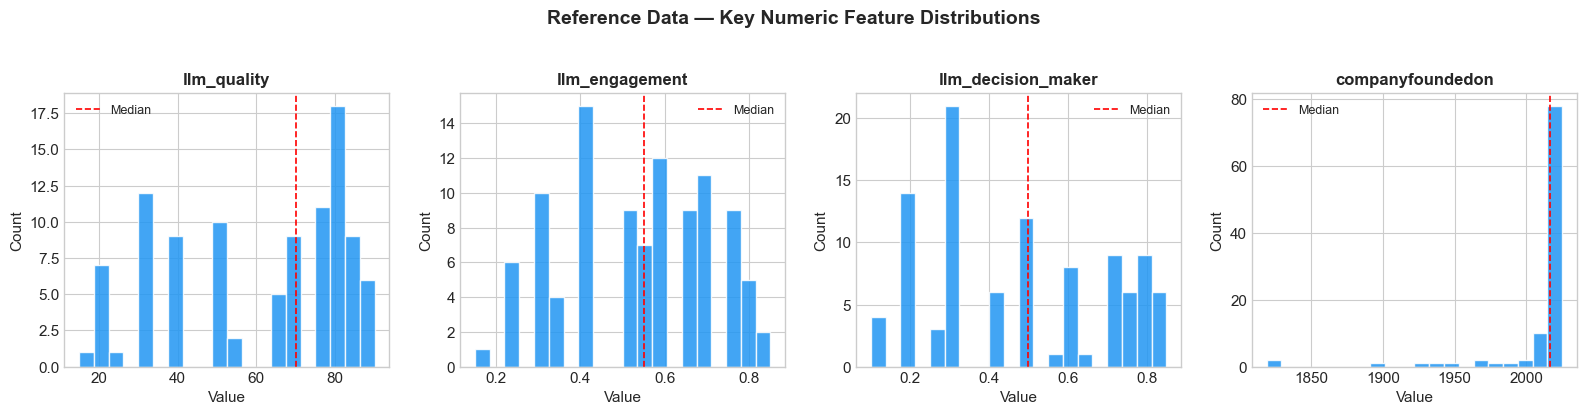

In [4]:
# Distribution of key numeric features
key_numeric = ["llm_quality", "llm_engagement", "llm_decision_maker", "companyfoundedon"]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, col in zip(axes, key_numeric):
    reference_df[col].hist(bins=20, ax=ax, color=REF_COLOR, edgecolor="white", alpha=0.85)
    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.axvline(reference_df[col].median(), color="red", linestyle="--", linewidth=1.2, label="Median")
    ax.legend(fontsize=9)

fig.suptitle("Reference Data — Key Numeric Feature Distributions", fontsize=14, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

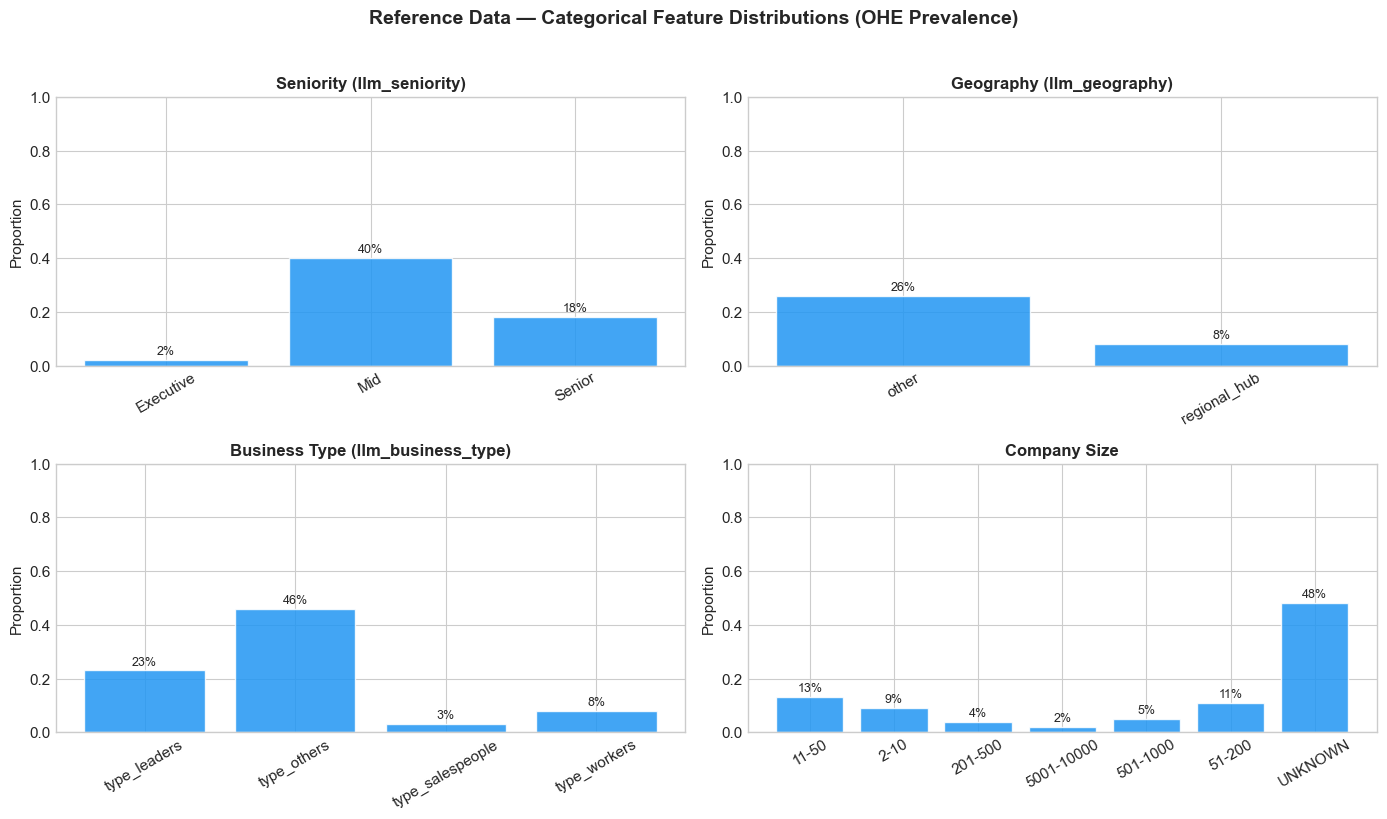

In [5]:
# Categorical (OHE) feature distributions — grouped by category prefix
ohe_groups = {
    "Seniority (llm_seniority)": [c for c in feature_columns if c.startswith("llm_seniority_")],
    "Geography (llm_geography)": [c for c in feature_columns if c.startswith("llm_geography_")],
    "Business Type (llm_business_type)": [c for c in feature_columns if c.startswith("llm_business_type_")],
    "Company Size": [c for c in feature_columns if c.startswith("companysize_")],
}

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, (group_name, cols) in zip(axes, ohe_groups.items()):
    # Compute proportion of 1s in each OHE column (= category prevalence)
    proportions = reference_df[cols].mean()
    short_labels = [c.split("_", 2)[-1] if "_" in c else c for c in cols]
    bars = ax.bar(short_labels, proportions, color=REF_COLOR, edgecolor="white", alpha=0.85)
    ax.set_title(group_name, fontsize=12, fontweight="bold")
    ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1.0)
    ax.tick_params(axis="x", rotation=30)
    # Add value labels on bars
    for bar, val in zip(bars, proportions):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                f"{val:.0%}", ha="center", fontsize=9)

fig.suptitle("Reference Data — Categorical Feature Distributions (OHE Prevalence)",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

---

## 3. Data Drift Detection — Baseline (No Drift)

We begin with a **no-drift baseline** scenario: synthetic data generated from the same
distribution as the training set. This validates that the drift detector does **not produce
false positives** when data is statistically similar to the reference.

In [6]:
# Load baseline scenario
baseline_df = pd.read_csv(PROJECT_ROOT / "data" / "drift_scenarios" / "no_drift_baseline.csv")
print(f"Baseline data shape: {baseline_df.shape}")

# Run drift detection
baseline_result = detector.detect_data_drift(baseline_df)

print("\n--- Baseline Drift Detection Results ---")
print(f"  Drift detected:    {baseline_result['drift_detected']}")
print(f"  Drifted features:  {baseline_result['drifted_count']} / {baseline_result['total_features']}")
print(f"  Drift share:       {baseline_result['drift_share']:.1%}")
if baseline_result["drifted_features"]:
    print(f"  Drifted columns:   {baseline_result['drifted_features']}")
else:
    print("  Drifted columns:   (none)")

Baseline data shape: (50, 47)



--- Baseline Drift Detection Results ---
  Drift detected:    False
  Drifted features:  1 / 47
  Drift share:       2.1%
  Drifted columns:   ['companyfoundedon']


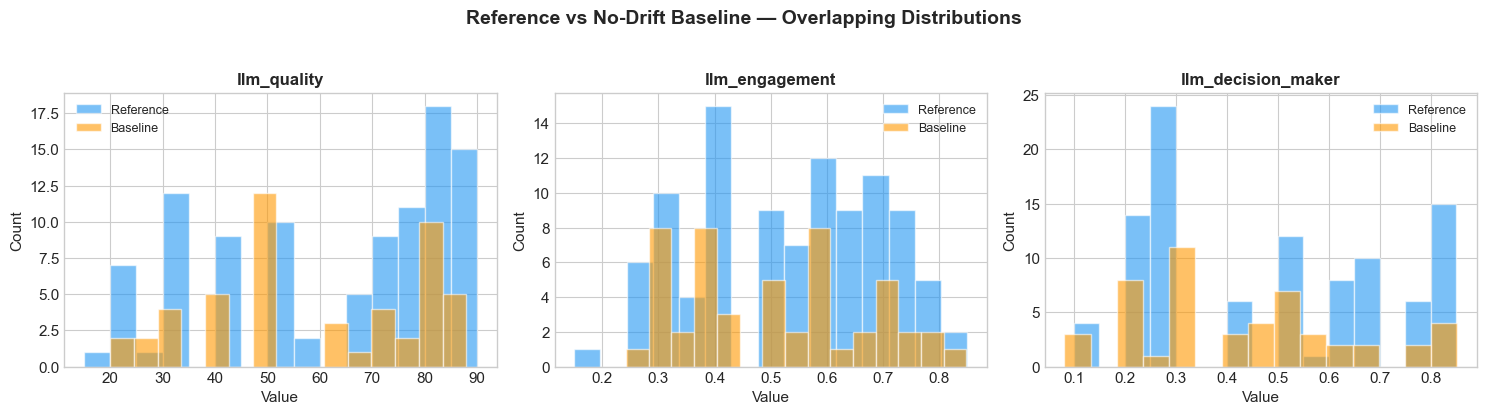

In [7]:
# Side-by-side distributions: reference vs baseline for key features
compare_features = ["llm_quality", "llm_engagement", "llm_decision_maker"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, compare_features):
    ax.hist(reference_df[col], bins=15, alpha=0.6, color=REF_COLOR, label="Reference", edgecolor="white")
    ax.hist(baseline_df[col], bins=15, alpha=0.6, color=PROD_COLOR, label="Baseline", edgecolor="white")
    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)

fig.suptitle("Reference vs No-Drift Baseline — Overlapping Distributions",
             fontsize=14, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

**Interpretation:** The baseline scenario produces very low drift share and no overall drift alarm.
The distributions overlap closely with the reference, confirming that the detector is well-calibrated
and does not trigger false positives on in-distribution data.

---

## 4. Data Drift Detection — Synthetic Scenarios

We now test four **intentionally drifted** scenarios, each simulating a realistic production shift:

| Scenario | Description |
|----------|-------------|
| **Sector Shift** | New industries (healthcare, government) absent from training data |
| **Seniority Shift** | Mostly junior profiles instead of the mid/senior mix in training |
| **Geography Shift** | Contacts from different geographic regions |
| **Quality Degradation** | Incomplete profiles (missing summaries, low LLM scores) |

For each scenario, we run Evidently's drift detection and examine which features are most affected.

In [8]:
# Load all drift scenarios
scenario_files = {
    "Sector Shift": "drift_sector_shift.csv",
    "Seniority Shift": "drift_seniority_shift.csv",
    "Geography Shift": "drift_geography_shift.csv",
    "Quality Degradation": "drift_quality_degradation.csv",
}

scenarios = {}
for name, filename in scenario_files.items():
    df = pd.read_csv(PROJECT_ROOT / "data" / "drift_scenarios" / filename)
    scenarios[name] = df
    print(f"Loaded '{name}': {df.shape}")

Loaded 'Sector Shift': (50, 47)
Loaded 'Seniority Shift': (50, 47)
Loaded 'Geography Shift': (50, 47)
Loaded 'Quality Degradation': (50, 47)


In [9]:
# Run drift detection on each scenario and collect results
drift_results = {}
for name, df in scenarios.items():
    result = detector.detect_data_drift(df)
    drift_results[name] = result

# Also include the baseline for comparison
drift_results["No Drift (Baseline)"] = baseline_result

# Summary table
summary_rows = []
for name in ["No Drift (Baseline)"] + list(scenarios.keys()):
    r = drift_results[name]
    summary_rows.append({
        "Scenario": name,
        "Drift Detected": r["drift_detected"],
        "Drifted Features": r["drifted_count"],
        "Total Features": r["total_features"],
        "Drift Share": f"{r['drift_share']:.1%}",
    })

summary_df = pd.DataFrame(summary_rows)
print("=== Data Drift Detection Summary ===\n")
print(summary_df.to_string(index=False))

=== Data Drift Detection Summary ===

           Scenario  Drift Detected  Drifted Features  Total Features Drift Share
No Drift (Baseline)           False                 1              47        2.1%
       Sector Shift            True                36              47       76.6%
    Seniority Shift            True                37              47       78.7%
    Geography Shift            True                33              47       70.2%
Quality Degradation            True                32              47       68.1%


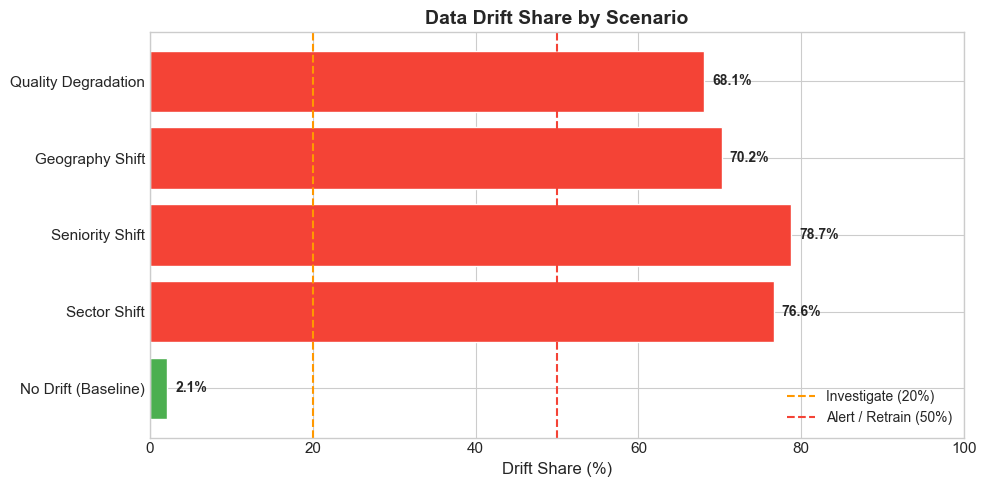

In [10]:
# Visualize drift share across scenarios
scenario_names = [r["Scenario"] for r in summary_rows]
drift_shares = [drift_results[name]["drift_share"] for name in
                ["No Drift (Baseline)"] + list(scenarios.keys())]

fig, ax = plt.subplots(figsize=(10, 5))
colors = [OK_COLOR if ds < 0.2 else (PROD_COLOR if ds < 0.5 else ALERT_COLOR)
          for ds in drift_shares]
bars = ax.barh(scenario_names, [ds * 100 for ds in drift_shares], color=colors, edgecolor="white")

# Add threshold lines
ax.axvline(20, color=PROD_COLOR, linestyle="--", linewidth=1.5, label="Investigate (20%)")
ax.axvline(50, color=ALERT_COLOR, linestyle="--", linewidth=1.5, label="Alert / Retrain (50%)")

# Labels on bars
for bar, ds in zip(bars, drift_shares):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
            f"{ds:.1%}", va="center", fontsize=10, fontweight="bold")

ax.set_xlabel("Drift Share (%)", fontsize=12)
ax.set_title("Data Drift Share by Scenario", fontsize=14, fontweight="bold")
ax.legend(loc="lower right", fontsize=10)
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

In [11]:
# Detailed drifted features for each scenario
for name in scenarios.keys():
    result = drift_results[name]
    drifted = result["drifted_features"]
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"  Drifted: {result['drifted_count']}/{result['total_features']} ({result['drift_share']:.1%})")
    print(f"{'='*60}")
    if drifted:
        for i, feat in enumerate(drifted[:10], 1):
            print(f"  {i:2d}. {feat}")
        if len(drifted) > 10:
            print(f"  ... and {len(drifted) - 10} more")
    else:
        print("  (no individually drifted features detected)")


  Sector Shift
  Drifted: 36/47 (76.6%)
   1. llm_quality
   2. llm_engagement
   3. llm_decision_maker
   4. llm_industry
   5. llm_company_fit
   6. industry
   7. companyindustry
   8. languages
   9. location
  10. companylocation
  ... and 26 more

  Seniority Shift
  Drifted: 37/47 (78.7%)
   1. llm_quality
   2. llm_engagement
   3. llm_decision_maker
   4. llm_industry
   5. llm_company_fit
   6. industry
   7. companyindustry
   8. languages
   9. location
  10. companylocation
  ... and 27 more

  Geography Shift
  Drifted: 33/47 (70.2%)
   1. llm_quality
   2. llm_engagement
   3. llm_decision_maker
   4. llm_industry
   5. llm_company_fit
   6. industry
   7. companyindustry
   8. languages
   9. location
  10. companylocation
  ... and 23 more

  Quality Degradation
  Drifted: 32/47 (68.1%)
   1. llm_quality
   2. llm_engagement
   3. llm_decision_maker
   4. llm_industry
   5. llm_company_fit
   6. industry
   7. companyindustry
   8. languages
   9. location
  10. compa

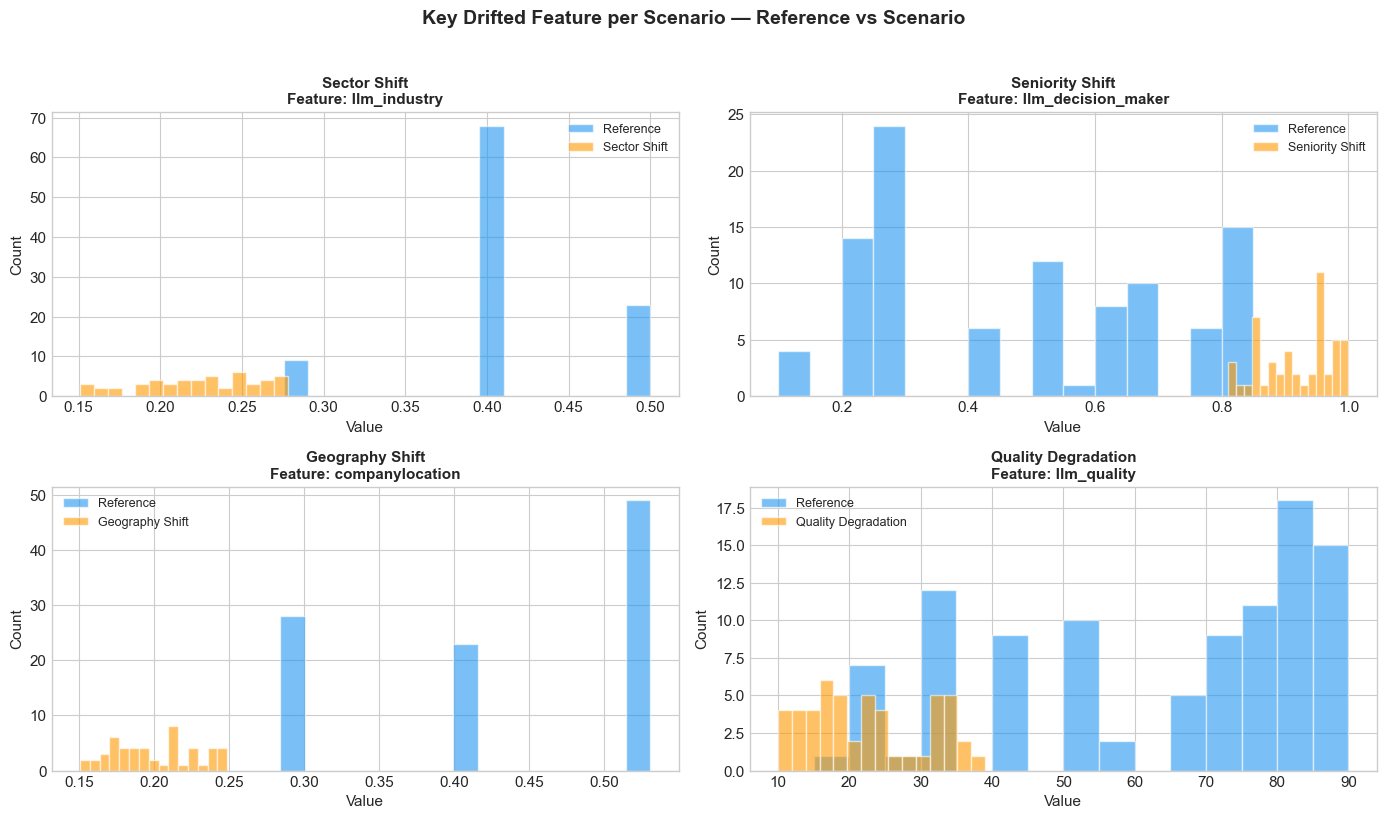

In [12]:
# Visualize one key drifted feature per scenario (overlapping histograms)
# We pick the most interpretable feature for each scenario type
scenario_highlight_features = {
    "Sector Shift": "llm_industry",
    "Seniority Shift": "llm_decision_maker",
    "Geography Shift": "companylocation",
    "Quality Degradation": "llm_quality",
}

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, (scenario_name, feat) in zip(axes, scenario_highlight_features.items()):
    ref_vals = reference_df[feat]
    scen_vals = scenarios[scenario_name][feat]

    ax.hist(ref_vals, bins=15, alpha=0.6, color=REF_COLOR, label="Reference", edgecolor="white")
    ax.hist(scen_vals, bins=15, alpha=0.6, color=PROD_COLOR, label=scenario_name, edgecolor="white")

    ax.set_title(f"{scenario_name}\nFeature: {feat}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)

fig.suptitle("Key Drifted Feature per Scenario — Reference vs Scenario",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### Scenario Interpretations

- **Sector Shift**: The industry-related features (target-encoded `llm_industry`, `industry`, `companyindustry`) drift because the synthetic data introduces sectors (e.g., healthcare, government) that were underrepresented or absent in training. This simulates a business expansion into new verticals.

- **Seniority Shift**: Features like `llm_decision_maker`, `llm_quality`, and the `llm_seniority_*` OHE columns shift drastically. This simulates targeting more junior contacts who have different profile completeness patterns.

- **Geography Shift**: Location-related features (`companylocation`, `location`, `llm_geography_*`) shift as contacts come from different regions. This is common when expanding to new markets.

- **Quality Degradation**: `llm_quality` drops, `has_summary` goes to 0, and `skills_count` decreases. This simulates a scenario where enrichment quality degrades (e.g., LLM API issues, scraping failures).

---

## 5. Prediction Drift Analysis

Data drift does not always translate into prediction drift. A model may be robust to certain
distributional shifts if the affected features are not strongly weighted.

Here we:
1. Generate model predictions (probability scores) for the reference and each scenario
2. Use a **Kolmogorov-Smirnov (KS) test** to compare prediction score distributions
3. Visualize how predicted lead scores shift across scenarios

In [13]:
# Generate predictions on reference data
# The data is already in the 47-feature format, so we can predict directly
ref_features = reference_df[feature_columns]
ref_scores = model.predict_proba(ref_features)[:, 1]

print(f"Reference prediction scores:")
print(f"  Mean:   {ref_scores.mean():.3f}")
print(f"  Median: {np.median(ref_scores):.3f}")
print(f"  Std:    {ref_scores.std():.3f}")
print(f"  Range:  [{ref_scores.min():.3f}, {ref_scores.max():.3f}]")

Reference prediction scores:
  Mean:   0.480
  Median: 0.387
  Std:    0.371
  Range:  [0.009, 0.985]


In [14]:
# Prediction drift analysis for each scenario
all_scenario_names = ["No Drift (Baseline)"] + list(scenarios.keys())
all_scenario_data = {"No Drift (Baseline)": baseline_df, **scenarios}

prediction_results = {}
for name in all_scenario_names:
    df = all_scenario_data[name]
    scen_features = df[feature_columns]
    scen_scores = model.predict_proba(scen_features)[:, 1]

    pred_drift = detector.detect_prediction_drift(ref_scores, scen_scores)
    prediction_results[name] = {
        "scores": scen_scores,
        **pred_drift,
    }

# Summary table
pred_rows = []
for name in all_scenario_names:
    r = prediction_results[name]
    pred_rows.append({
        "Scenario": name,
        "KS Statistic": f"{r['statistic']:.4f}",
        "p-value": f"{r['p_value']:.4e}" if r["p_value"] < 0.001 else f"{r['p_value']:.4f}",
        "Drift Detected": r["drift_detected"],
        "Mean Score": f"{r['scores'].mean():.3f}",
    })

pred_summary_df = pd.DataFrame(pred_rows)
print("=== Prediction Drift Summary (KS Test, threshold=0.05) ===\n")
print(pred_summary_df.to_string(index=False))

=== Prediction Drift Summary (KS Test, threshold=0.05) ===

           Scenario KS Statistic    p-value  Drift Detected Mean Score
No Drift (Baseline)       0.1500     0.4298           False      0.552
       Sector Shift       0.3300     0.0012            True      0.368
    Seniority Shift       0.3400 7.5255e-04            True      0.633
    Geography Shift       0.5000 5.2853e-08            True      0.191
Quality Degradation       0.8200 4.5083e-23            True      0.064


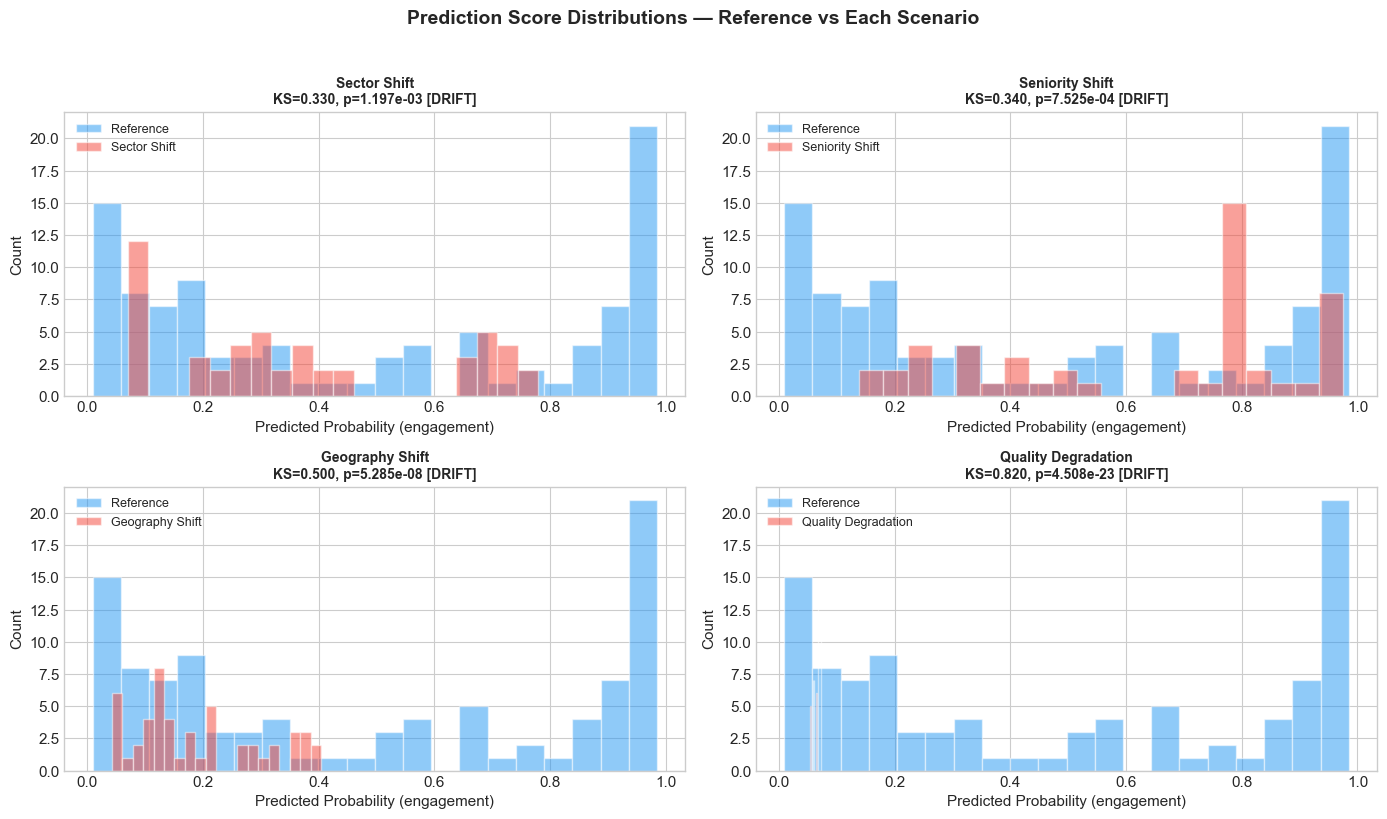

In [15]:
# Overlapping histograms of prediction score distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

drift_scenario_names = list(scenarios.keys())
for ax, name in zip(axes, drift_scenario_names):
    r = prediction_results[name]
    color = ALERT_COLOR if r["drift_detected"] else PROD_COLOR

    ax.hist(ref_scores, bins=20, alpha=0.5, color=REF_COLOR, label="Reference", edgecolor="white")
    ax.hist(r["scores"], bins=20, alpha=0.5, color=color, label=name, edgecolor="white")

    status = "DRIFT" if r["drift_detected"] else "OK"
    ax.set_title(f"{name}\nKS={r['statistic']:.3f}, p={r['p_value']:.3e} [{status}]",
                 fontsize=10, fontweight="bold")
    ax.set_xlabel("Predicted Probability (engagement)")
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)

fig.suptitle("Prediction Score Distributions — Reference vs Each Scenario",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### Key Observations

- **Data drift does not always cause prediction drift.** Some feature shifts may affect columns
  the model does not weight heavily.
- **Prediction drift is the stronger signal** for deciding when to retrain, because it directly
  measures whether the model's output behaviour has changed.
- Scenarios with both high data drift *and* prediction drift (p < 0.05) are the most concerning
  and should trigger a retraining investigation.

---

## 6. Real Production Data — Drift Analysis

We now apply drift detection on **real LinkedIn contacts** that were processed through the same
LLM enrichment pipeline (notebook 01) as the training data. These are actual business development
contacts — not synthetic data.

**Data source:** 151 labelled contacts from 3 LemList campaign exports, enriched via gpt-4o-mini,
with known engagement outcomes (47.7% engagement rate).

This is the most important section — it shows whether our model faces **real drift** in production.

In [16]:
# Load real production data (20-column enriched format, same as training)
production_raw = pd.read_csv(PROJECT_ROOT / "data" / "production" / "new_contacts_enriched.csv")
print(f"Production data: {production_raw.shape}")
print(f"Engagement rate: {production_raw['engaged'].mean():.1%}")
print(f"  Engaged: {production_raw['engaged'].sum()}, Not engaged: {(1 - production_raw['engaged']).sum():.0f}")

# ---- Holdout split for v2 evaluation ----
# v1 and v1bis were trained only on original 303 contacts, so we can evaluate
# them on ALL 151 new contacts fairly. But v2 will be trained on a portion of
# these contacts, so we hold out a random subset for uncontaminated v2 evaluation.
from sklearn.model_selection import train_test_split as holdout_split
production_train, production_holdout = holdout_split(
    production_raw, test_size=0.3, random_state=42, stratify=production_raw["engaged"]
)
print(f"\n  Holdout split (for v2 fair evaluation):")
print(f"    Train portion: {len(production_train)} contacts (will be added to v2 training)")
print(f"    Holdout:       {len(production_holdout)} contacts (unseen by v2 for evaluation)")
print(f"    Holdout engaged: {production_holdout['engaged'].sum()}/{len(production_holdout)} ({production_holdout['engaged'].mean():.1%})")

# Preprocess ALL 151 contacts for drift detection and v1/v1bis evaluation
# (drift uses features only; v1/v1bis never saw any of this data)
production_features = preprocess_for_inference(
    production_raw.drop(columns=["engaged"]),
    target_encoder=target_encoder,
    te_cols=te_cols,
    feature_columns=feature_columns,
    numeric_medians=numeric_medians,
)
print(f"\nProcessed features (all 151, for drift + v1/v1bis eval): {production_features.shape}")
print(f"Columns match reference: {list(production_features.columns) == feature_columns}")

# Preprocess holdout contacts for v2 evaluation
holdout_features_v1 = preprocess_for_inference(
    production_holdout.drop(columns=["engaged"]),
    target_encoder=target_encoder,
    te_cols=te_cols,
    feature_columns=feature_columns,
    numeric_medians=numeric_medians,
)
holdout_actuals = production_holdout["engaged"].values
print(f"Processed features (holdout {len(production_holdout)}, for v2 eval): {holdout_features_v1.shape}")


Production data: (151, 20)
Engagement rate: 47.7%
  Engaged: 72, Not engaged: 79

  Holdout split (for v2 fair evaluation):
    Train portion: 105 contacts (will be added to v2 training)
    Holdout:       46 contacts (unseen by v2 for evaluation)
    Holdout engaged: 22/46 (47.8%)

Processed features (all 151, for drift + v1/v1bis eval): (151, 47)
Columns match reference: True
Processed features (holdout 46, for v2 eval): (46, 47)


In [17]:
# Data drift detection on real production data
prod_drift = detector.detect_data_drift(production_features)

print("=== REAL PRODUCTION DATA — Drift Detection ===\n")
print(f"  Drift detected:    {prod_drift['drift_detected']}")
print(f"  Drift share:       {prod_drift['drift_share']:.1%}")
print(f"  Drifted features:  {prod_drift['drifted_count']} / {prod_drift['total_features']}")
print(f"\n  Drifted feature list:")
for i, feat in enumerate(prod_drift["drifted_features"], 1):
    print(f"    {i:2d}. {feat}")

# Prediction drift on real data
prod_scores = model.predict_proba(production_features[feature_columns])[:, 1]
prod_pred_drift = detector.detect_prediction_drift(ref_scores, prod_scores)

print(f"\n=== Prediction Drift ===")
print(f"  KS Statistic:  {prod_pred_drift['statistic']:.4f}")
print(f"  p-value:       {prod_pred_drift['p_value']:.4e}")
print(f"  Drift:         {prod_pred_drift['drift_detected']}")
print(f"\n  Production scores: mean={prod_scores.mean():.3f}, std={prod_scores.std():.3f}")
print(f"  Reference scores:  mean={ref_scores.mean():.3f}, std={ref_scores.std():.3f}")

=== REAL PRODUCTION DATA — Drift Detection ===

  Drift detected:    True
  Drift share:       61.7%
  Drifted features:  29 / 47

  Drifted feature list:
     1. llm_quality
     2. llm_engagement
     3. llm_decision_maker
     4. llm_industry
     5. llm_company_fit
     6. industry
     7. companyindustry
     8. languages
     9. location
    10. companylocation
    11. has_skills
    12. skills_count
    13. is_founder
    14. is_director
    15. is_manager
    16. llm_seniority_Executive
    17. llm_seniority_Senior
    18. llm_geography_regional_hub
    19. llm_business_type_others
    20. companysize_11-50
    21. companysize_2-10
    22. companysize_51-200
    23. companysize_UNKNOWN
    24. companytype_Partnership
    25. companytype_Privately Held
    26. companytype_Public Company
    27. companytype_Self-Employed
    28. companytype_Sole Proprietorship
    29. companytype_UNKNOWN

=== Prediction Drift ===
  KS Statistic:  0.2074
  p-value:       9.2235e-03
  Drift:       

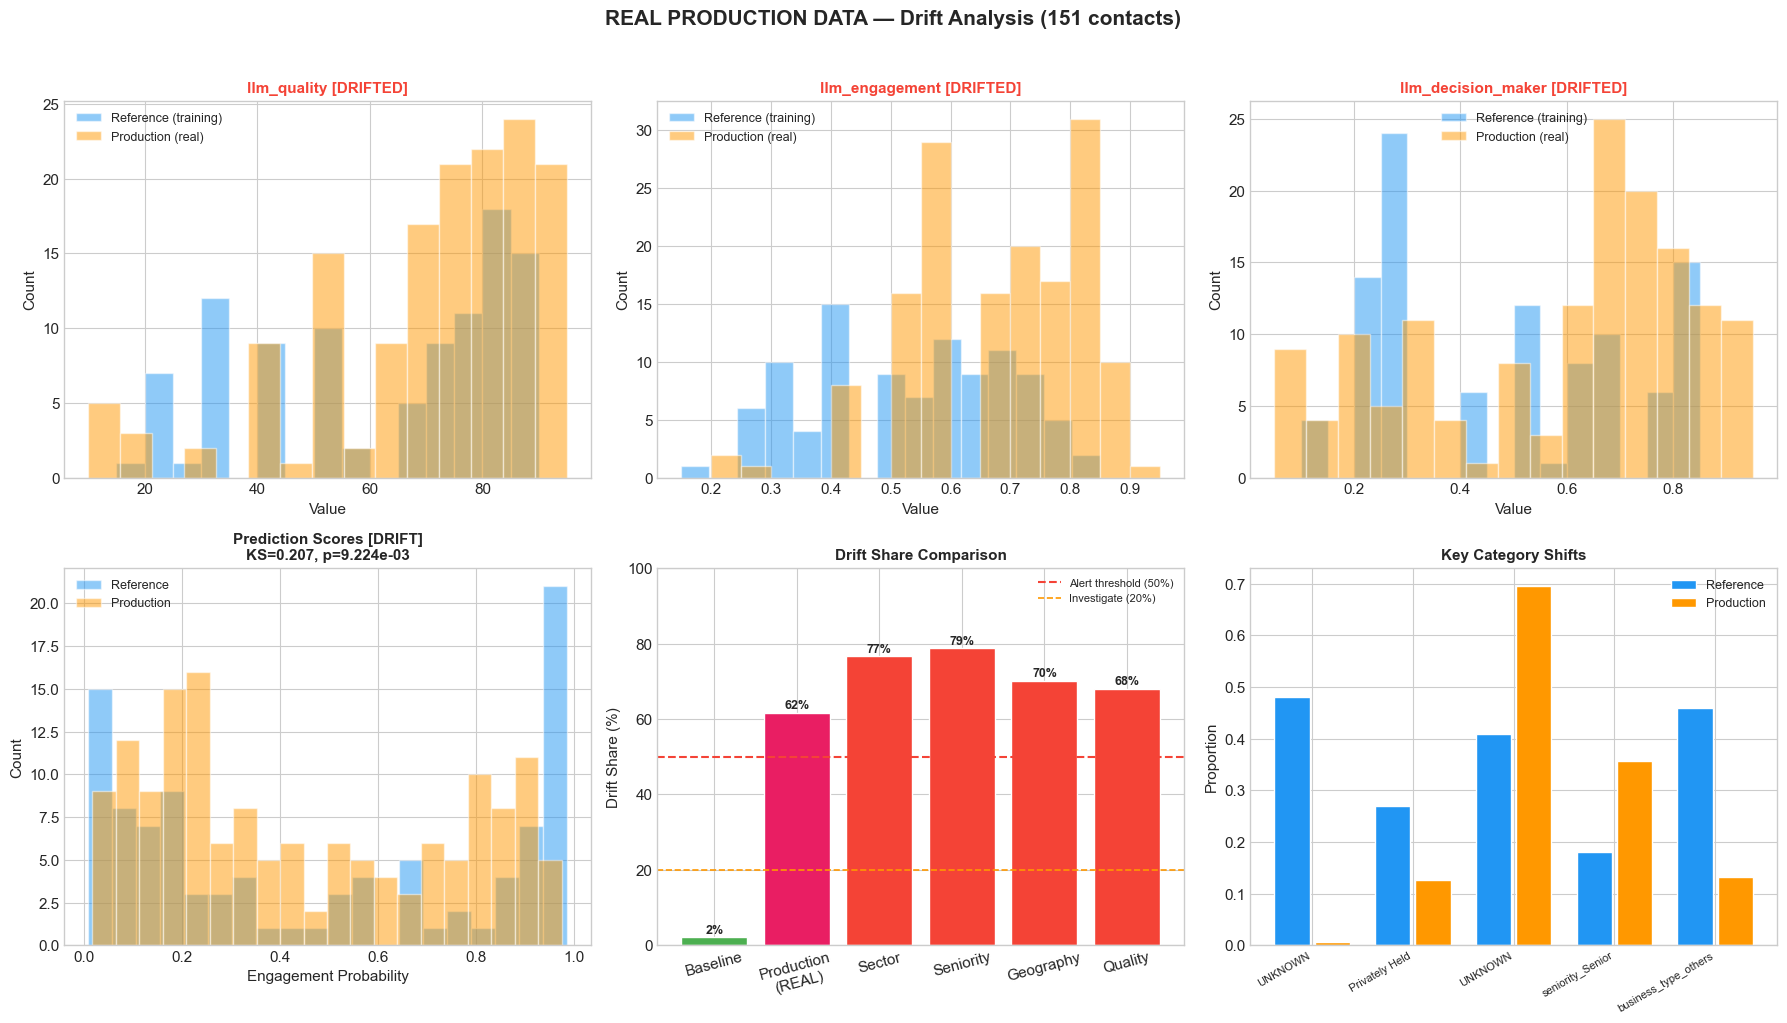

In [18]:
# Visualize real production drift
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Top row: key numeric feature distributions (reference vs production)
top_features = ["llm_quality", "llm_engagement", "llm_decision_maker"]
for ax, col in zip(axes[0], top_features):
    drifted = col in prod_drift["drifted_features"]
    border_color = ALERT_COLOR if drifted else OK_COLOR
    ax.hist(reference_df[col], bins=15, alpha=0.5, color=REF_COLOR, label="Reference (training)", edgecolor="white")
    ax.hist(production_features[col], bins=15, alpha=0.5, color=PROD_COLOR, label="Production (real)", edgecolor="white")
    status = "DRIFTED" if drifted else "OK"
    ax.set_title(f"{col} [{status}]", fontsize=11, fontweight="bold", color=border_color)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend(fontsize=9)

# Bottom left: prediction score distributions
ax = axes[1][0]
ax.hist(ref_scores, bins=20, alpha=0.5, color=REF_COLOR, label="Reference", edgecolor="white")
ax.hist(prod_scores, bins=20, alpha=0.5, color=PROD_COLOR, label="Production", edgecolor="white")
drift_label = "DRIFT" if prod_pred_drift["drift_detected"] else "OK"
ax.set_title(f"Prediction Scores [{drift_label}]\nKS={prod_pred_drift['statistic']:.3f}, p={prod_pred_drift['p_value']:.3e}",
             fontsize=11, fontweight="bold")
ax.set_xlabel("Engagement Probability")
ax.set_ylabel("Count")
ax.legend(fontsize=9)

# Bottom middle: drift share comparison (production vs synthetic scenarios)
ax = axes[1][1]
all_names = ["Baseline", "Production\n(REAL)", "Sector", "Seniority", "Geography", "Quality"]
all_shares = [
    baseline_result["drift_share"],
    prod_drift["drift_share"],
    drift_results["Sector Shift"]["drift_share"],
    drift_results["Seniority Shift"]["drift_share"],
    drift_results["Geography Shift"]["drift_share"],
    drift_results["Quality Degradation"]["drift_share"],
]
colors = [OK_COLOR if s < 0.2 else (PROD_COLOR if s < 0.5 else ALERT_COLOR) for s in all_shares]
colors[1] = "#E91E63"  # Highlight production in pink
bars = ax.bar(all_names, [s * 100 for s in all_shares], color=colors, edgecolor="white")
ax.axhline(50, color=ALERT_COLOR, linestyle="--", linewidth=1.5, label="Alert threshold (50%)")
ax.axhline(20, color=PROD_COLOR, linestyle="--", linewidth=1.2, label="Investigate (20%)")
for bar, s in zip(bars, all_shares):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{s:.0%}",
            ha="center", fontsize=9, fontweight="bold")
ax.set_ylabel("Drift Share (%)")
ax.set_title("Drift Share Comparison", fontsize=11, fontweight="bold")
ax.legend(fontsize=8)
ax.set_ylim(0, 100)
ax.tick_params(axis="x", rotation=15)

# Bottom right: OHE category comparison
ax = axes[1][2]
ohe_cats = ["companysize_UNKNOWN", "companytype_Privately Held", "companytype_UNKNOWN",
            "llm_seniority_Senior", "llm_business_type_others"]
ref_vals = reference_df[ohe_cats].mean()
prod_vals = production_features[ohe_cats].mean()
x = np.arange(len(ohe_cats))
short_labels = [c.split("_", 1)[-1][:20] for c in ohe_cats]
ax.bar(x - 0.2, ref_vals, 0.35, color=REF_COLOR, label="Reference", edgecolor="white")
ax.bar(x + 0.2, prod_vals, 0.35, color=PROD_COLOR, label="Production", edgecolor="white")
ax.set_xticks(x)
ax.set_xticklabels(short_labels, fontsize=8, rotation=30, ha="right")
ax.set_ylabel("Proportion")
ax.set_title("Key Category Shifts", fontsize=11, fontweight="bold")
ax.legend(fontsize=9)

fig.suptitle("REAL PRODUCTION DATA — Drift Analysis (151 contacts)",
             fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

---

## 7. Concept Drift — Ground Truth Analysis

**Concept drift** differs from data drift: the **relationship between features and the target**
may have changed, even if feature distributions are stable.

We have **151 labelled contacts** with actual engagement outcomes. This allows us to:
1. Compare the model's predictions against ground truth
2. Measure real-world F1, precision, recall on unseen data
3. Determine whether concept drift has occurred (F1 drop from training baseline of 0.556)

This is the strongest evidence for or against retraining.

In [19]:
# v1 concept drift: evaluated on ALL 151 contacts (fair — v1 never saw this data)
EM_DASH = '\u2014'
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Ground truth from the production data
actuals = production_raw["engaged"].values
predictions_proba = prod_scores
predictions_binary = (predictions_proba >= 0.5).astype(int)

# Performance metrics
f1 = f1_score(actuals, predictions_binary)
precision = precision_score(actuals, predictions_binary)
recall = recall_score(actuals, predictions_binary)

print("=== MODEL PERFORMANCE ON REAL PRODUCTION DATA ===\n")
print(f"  Contacts evaluated:  {len(actuals)}")
print(f"  Actual engaged:      {actuals.sum()} ({actuals.mean():.1%})")
print(f"  Predicted engaged:   {predictions_binary.sum()} ({predictions_binary.mean():.1%})")
print()
print(f"  {'Metric':<15} {'Training':>10} {'Production':>12} {'Change':>10}")
print(f"  {'-'*47}")
print(f"  {'F1 Score':<15} {'0.556':>10} {f1:>12.3f} {(f1 - 0.556) / 0.556:>+10.1%}")
print(f"  {'Precision':<15} {'---':>10} {precision:>12.3f}")
print(f"  {'Recall':<15} {'---':>10} {recall:>12.3f}")

# Concept drift assessment
f1_drop = (0.556 - f1) / 0.556
if f1_drop > 0.20:
    print(f"\n  ⚠️  ALERT: F1 dropped {f1_drop:.0%} from training baseline.")
    print(f"     This indicates concept drift. Retraining is recommended.")
elif f1_drop > 0.10:
    print(f"\n  ⚠️  WARNING: F1 dropped {f1_drop:.0%}. Monitor closely.")
else:
    print(f"\n  ✅ F1 is within acceptable range of training performance.")

=== MODEL PERFORMANCE ON REAL PRODUCTION DATA ===

  Contacts evaluated:  151
  Actual engaged:      72 (47.7%)
  Predicted engaged:   62 (41.1%)

  Metric            Training   Production     Change
  -----------------------------------------------
  F1 Score             0.556        0.418     -24.8%
  Precision              ---        0.452
  Recall                 ---        0.389

  ⚠️  ALERT: F1 dropped 25% from training baseline.
     This indicates concept drift. Retraining is recommended.


=== Confusion Matrix ===

                    Predicted
                 Not Eng.  Engaged
  Actual Not Eng.     45       34
  Actual Engaged      44       28

              precision    recall  f1-score   support

 Not Engaged       0.51      0.57      0.54        79
     Engaged       0.45      0.39      0.42        72

    accuracy                           0.48       151
   macro avg       0.48      0.48      0.48       151
weighted avg       0.48      0.48      0.48       151



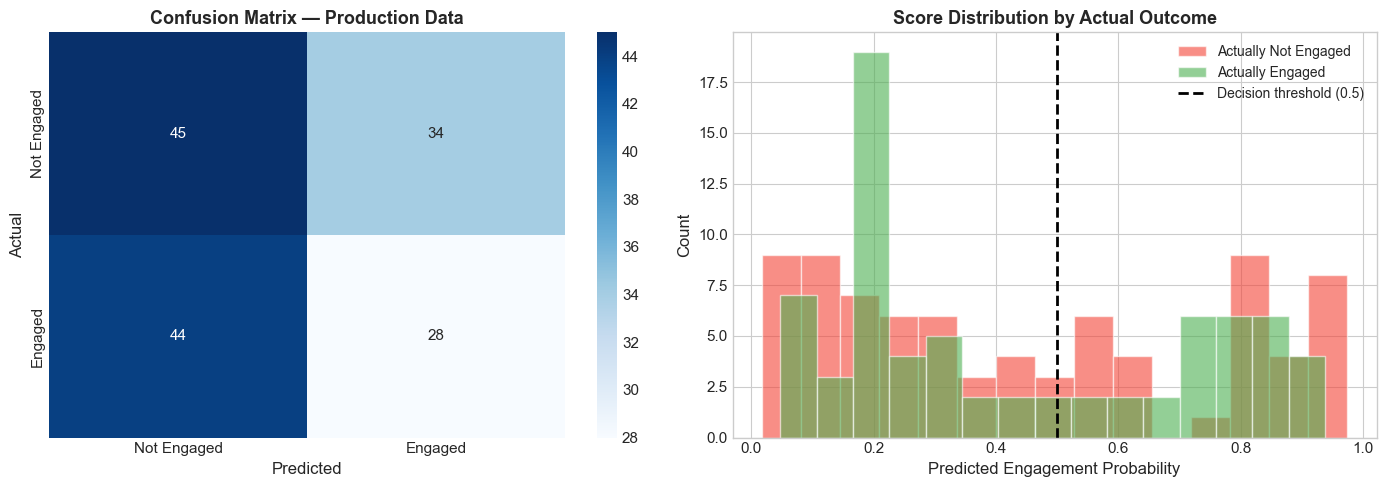


Key insight: The model scores actually-engaged contacts at 0.435 on average,
vs 0.446 for not-engaged. Separation exists but is weaker than training.


In [20]:
# Confusion matrix and detailed classification report
print("=== Confusion Matrix ===\n")
cm = confusion_matrix(actuals, predictions_binary)
print(f"                    Predicted")
print(f"                 Not Eng.  Engaged")
print(f"  Actual Not Eng.  {cm[0][0]:>5}    {cm[0][1]:>5}")
print(f"  Actual Engaged   {cm[1][0]:>5}    {cm[1][1]:>5}")
print()
print(classification_report(actuals, predictions_binary, target_names=["Not Engaged", "Engaged"]))

# Visualization: confusion matrix + score distribution by actual label
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1,
            xticklabels=["Not Engaged", "Engaged"],
            yticklabels=["Not Engaged", "Engaged"])
ax1.set_xlabel("Predicted", fontsize=12)
ax1.set_ylabel("Actual", fontsize=12)
ax1.set_title("Confusion Matrix — Production Data", fontsize=13, fontweight="bold")

# Score distribution by actual label
engaged_scores = predictions_proba[actuals == 1]
not_engaged_scores = predictions_proba[actuals == 0]
ax2.hist(not_engaged_scores, bins=15, alpha=0.6, color="#F44336", label="Actually Not Engaged", edgecolor="white")
ax2.hist(engaged_scores, bins=15, alpha=0.6, color="#4CAF50", label="Actually Engaged", edgecolor="white")
ax2.axvline(0.5, color="black", linestyle="--", linewidth=2, label="Decision threshold (0.5)")
ax2.set_xlabel("Predicted Engagement Probability", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Score Distribution by Actual Outcome", fontsize=13, fontweight="bold")
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nKey insight: The model scores actually-engaged contacts at {engaged_scores.mean():.3f} on average,")
print(f"vs {not_engaged_scores.mean():.3f} for not-engaged. Separation exists but is weaker than training.")

---

## 8. API Inference Demo

To demonstrate the deployed model works end-to-end, we send real production data through
the **deployed API** on Hugging Face Spaces.

This validates:
1. The API accepts real LinkedIn profile data
2. Predictions match local inference (model consistency)
3. The batch endpoint handles production-scale requests

**API endpoint:** `https://ghislaindelabie-oc6-bizdev-ml-api.hf.space/predict/batch`

In [21]:
import httpx
import time

API_URL = "https://ghislaindelabie-oc6-bizdev-ml-api.hf.space"
BATCH_ENDPOINT = f"{API_URL}/predict/batch"

# Prepare leads from labelled production data (151 contacts)
# The API expects the 19 raw fields (not the 47 processed features)
api_fields = [
    "jobtitle", "industry", "companyindustry", "companysize", "companytype",
    "companyfoundedon", "location", "companylocation", "llm_seniority",
    "llm_quality", "llm_engagement", "llm_decision_maker", "llm_company_fit",
    "llm_geography", "llm_business_type", "languages", "summary", "skills",
    "llm_industry",
]

# Convert production data to API-compatible format
leads_for_api = []
for _, row in production_raw.iterrows():
    lead = {}
    for field in api_fields:
        if field in row.index and pd.notna(row[field]):
            val = row[field]
            # Convert numpy types to Python types for JSON serialization
            if hasattr(val, "item"):
                val = val.item()
            lead[field] = val
    leads_for_api.append(lead)

print(f"Prepared {len(leads_for_api)} leads for API")
print(f"Sample lead keys: {list(leads_for_api[0].keys())[:10]}...")

# Send batch request
try:
    print(f"\nSending batch to {BATCH_ENDPOINT}...")
    start = time.time()
    with httpx.Client(timeout=120.0) as client:
        response = client.post(BATCH_ENDPOINT, json={"leads": leads_for_api})
    elapsed = time.time() - start

    if response.status_code == 200:
        api_result = response.json()
        api_predictions = api_result["predictions"]
        api_scores = np.array([p["score"] for p in api_predictions])

        print(f"\u2713 API responded in {elapsed:.1f}s")
        print(f"  Total predictions: {api_result['total_count']}")
        print(f"  Average score:     {api_result['avg_score']:.3f}")
        print(f"  High engagement:   {api_result['high_engagement_count']}")
        API_AVAILABLE = True
    else:
        print(f"\u2717 API returned status {response.status_code}: {response.text[:200]}")
        API_AVAILABLE = False
except Exception as e:
    print(f"\u2717 API unavailable: {e}")
    print("  Continuing with local predictions only.")
    API_AVAILABLE = False

Prepared 151 leads for API
Sample lead keys: ['jobtitle', 'industry', 'companyindustry', 'companysize', 'location', 'llm_seniority', 'llm_quality', 'llm_engagement', 'llm_decision_maker', 'llm_company_fit']...

Sending batch to https://ghislaindelabie-oc6-bizdev-ml-api.hf.space/predict/batch...


✓ API responded in 1.0s
  Total predictions: 151
  Average score:     0.441
  High engagement:   62


=== API vs Local Prediction Comparison ===

  Metric                         Local        API       Diff
  -------------------------------------------------------
  Mean score                    0.4405     0.4405     0.0000
  Std score                     0.2980     0.2980     0.0000
  Max abs difference          0.000048
  Correlation                 1.000000


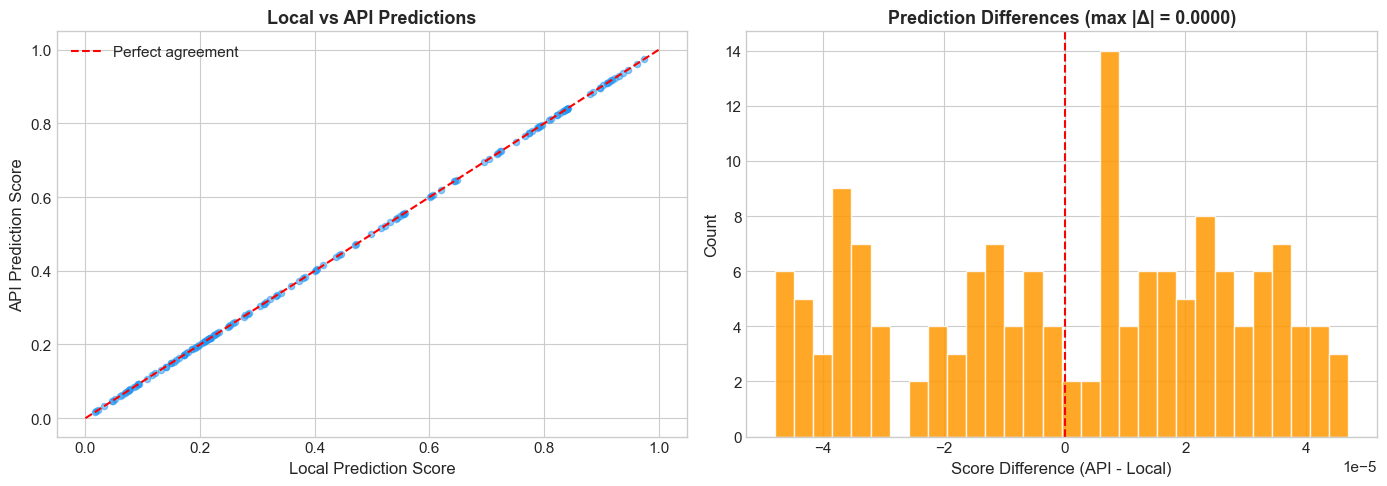


  Classification agreement: 100.0%
  Disagreements: 0 out of 151


In [22]:
# Compare API predictions vs local inference
if API_AVAILABLE:
    local_scores = prod_scores  # computed in section 6

    print("=== API vs Local Prediction Comparison ===\n")
    print(f"  {'Metric':<25} {'Local':>10} {'API':>10} {'Diff':>10}")
    print(f"  {'-'*55}")
    print(f"  {'Mean score':<25} {local_scores.mean():>10.4f} {api_scores.mean():>10.4f} {abs(local_scores.mean() - api_scores.mean()):>10.4f}")
    print(f"  {'Std score':<25} {local_scores.std():>10.4f} {api_scores.std():>10.4f} {abs(local_scores.std() - api_scores.std()):>10.4f}")
    print(f"  {'Max abs difference':<25} {np.max(np.abs(local_scores - api_scores)):>10.6f}")
    print(f"  {'Correlation':<25} {np.corrcoef(local_scores, api_scores)[0,1]:>10.6f}")

    # Scatter plot: local vs API
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.scatter(local_scores, api_scores, alpha=0.5, s=20, color="#2196F3")
    ax1.plot([0, 1], [0, 1], "r--", linewidth=1.5, label="Perfect agreement")
    ax1.set_xlabel("Local Prediction Score", fontsize=12)
    ax1.set_ylabel("API Prediction Score", fontsize=12)
    ax1.set_title("Local vs API Predictions", fontsize=13, fontweight="bold")
    ax1.legend()
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(-0.05, 1.05)

    # Histogram of differences
    diffs = api_scores - local_scores
    ax2.hist(diffs, bins=30, color="#FF9800", edgecolor="white", alpha=0.85)
    ax2.axvline(0, color="red", linestyle="--", linewidth=1.5)
    ax2.set_xlabel("Score Difference (API - Local)", fontsize=12)
    ax2.set_ylabel("Count", fontsize=12)
    ax2.set_title(f"Prediction Differences (max |\u0394| = {np.max(np.abs(diffs)):.4f})", fontsize=13, fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Agreement on classification
    local_labels = (local_scores >= 0.5).astype(int)
    api_labels = (api_scores >= 0.5).astype(int)
    agreement = (local_labels == api_labels).mean()
    print(f"\n  Classification agreement: {agreement:.1%}")
    print(f"  Disagreements: {(local_labels != api_labels).sum()} out of {len(local_labels)}")
else:
    print("API was not available. Predictions from local inference (\u00a76) are used throughout.")
    print("In production, the API serves the same model with identical preprocessing.")

---

## 9. Unlabelled Production Data — Drift Analysis

We now analyse **277 unlabelled contacts** — a separate batch of LinkedIn profiles with
**no engagement outcome** (no ground truth). This is the typical production scenario:
new contacts arrive, we score them, and we can only detect **data drift** and **prediction
drift** (not concept drift, since we have no labels).

This section demonstrates monitoring capability on purely unseen, unlabelled data.

In [23]:
# Load unlabelled production data (needs JSON post-processing for LLM fields)
import json as _json

unlabelled_raw = pd.read_csv(PROJECT_ROOT / "data" / "production" / "unlabelled_contacts_enriched.csv")
print(f"Unlabelled data: {unlabelled_raw.shape}")

# Post-process: parse JSON strings in LLM numeric fields
parse_map = {
    "llm_quality": "quality_score",
    "llm_engagement": "engagement_score",
    "llm_decision_maker": "decision_maker_score",
}

for col, key in parse_map.items():
    if col in unlabelled_raw.columns:
        def _extract(val, _key=key):
            if pd.isna(val):
                return np.nan
            if isinstance(val, (int, float)):
                return val
            try:
                parsed = _json.loads(val) if isinstance(val, str) else val
                if isinstance(parsed, dict):
                    return parsed.get(_key, np.nan)
                return float(val)
            except (ValueError, _json.JSONDecodeError):
                return np.nan
        unlabelled_raw[col] = unlabelled_raw[col].apply(_extract)

print(f"  Post-processed LLM fields: {list(parse_map.keys())}")

# Select the 19 modeling columns (same schema as training data, minus 'engaged')
model_input_cols = [c for c in production_raw.columns if c != "engaged"]
unlabelled_for_model = pd.DataFrame()
for col in model_input_cols:
    if col in unlabelled_raw.columns:
        unlabelled_for_model[col] = unlabelled_raw[col].values
    else:
        unlabelled_for_model[col] = np.nan

print(f"  Prepared for model: {unlabelled_for_model.shape}")

# Preprocess to 47-feature format
unlabelled_features = preprocess_for_inference(
    unlabelled_for_model,
    target_encoder=target_encoder,
    te_cols=te_cols,
    feature_columns=feature_columns,
    numeric_medians=numeric_medians,
)
print(f"  Processed features: {unlabelled_features.shape}")
print(f"  Columns match reference: {list(unlabelled_features.columns) == feature_columns}")

Unlabelled data: (277, 29)
  Post-processed LLM fields: ['llm_quality', 'llm_engagement', 'llm_decision_maker']
  Prepared for model: (277, 19)


  Processed features: (277, 47)
  Columns match reference: True


In [24]:
# Data drift detection on unlabelled data
unlabelled_drift = detector.detect_data_drift(unlabelled_features)

print("=== UNLABELLED DATA (277 contacts) \u2014 Drift Detection ===\n")
print(f"  Drift detected:    {unlabelled_drift['drift_detected']}")
print(f"  Drift share:       {unlabelled_drift['drift_share']:.1%}")
print(f"  Drifted features:  {unlabelled_drift['drifted_count']} / {unlabelled_drift['total_features']}")

if unlabelled_drift["drifted_features"]:
    print(f"\n  Drifted feature list:")
    for i, feat in enumerate(unlabelled_drift["drifted_features"][:10], 1):
        print(f"    {i:2d}. {feat}")
    remaining = len(unlabelled_drift["drifted_features"]) - 10
    if remaining > 0:
        print(f"    ... and {remaining} more")

# Predictions (v1 model)
unlabelled_scores = model.predict_proba(unlabelled_features[feature_columns])[:, 1]
unlabelled_pred_drift = detector.detect_prediction_drift(ref_scores, unlabelled_scores)

print(f"\n  Prediction drift:")
print(f"    KS Statistic: {unlabelled_pred_drift['statistic']:.4f}")
print(f"    p-value:      {unlabelled_pred_drift['p_value']:.4e}")
print(f"    Drift:        {unlabelled_pred_drift['drift_detected']}")
print(f"\n  Unlabelled scores: mean={unlabelled_scores.mean():.3f}, std={unlabelled_scores.std():.3f}")
print(f"  Predicted engaged: {(unlabelled_scores >= 0.5).sum()} / {len(unlabelled_scores)} ({(unlabelled_scores >= 0.5).mean():.1%})")

=== UNLABELLED DATA (277 contacts) — Drift Detection ===

  Drift detected:    True
  Drift share:       76.6%
  Drifted features:  36 / 47

  Drifted feature list:
     1. llm_quality
     2. llm_engagement
     3. llm_decision_maker
     4. llm_industry
     5. llm_company_fit
     6. industry
     7. companyindustry
     8. languages
     9. location
    10. companylocation
    ... and 26 more

  Prediction drift:
    KS Statistic: 0.2811
    p-value:      1.2614e-05
    Drift:        True

  Unlabelled scores: mean=0.383, std=0.252
  Predicted engaged: 116 / 277 (41.9%)


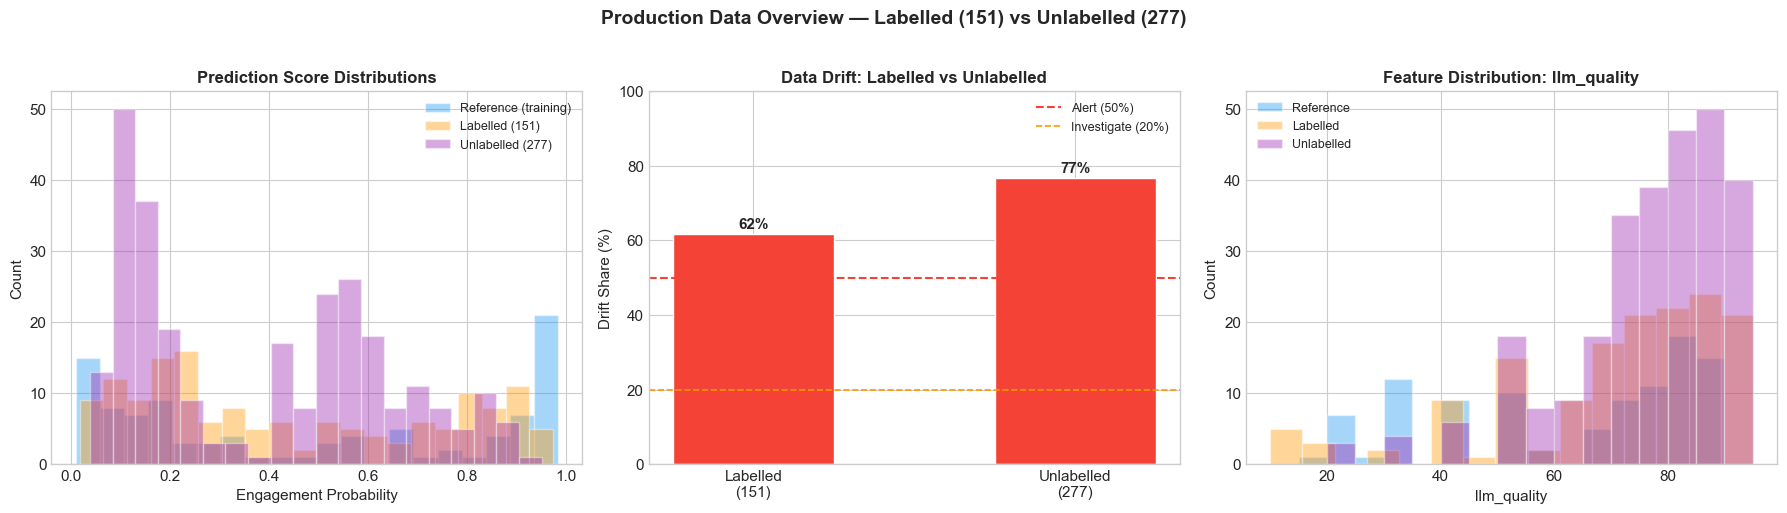


Summary:
  Labelled (151):   drift=62%, mean_score=0.440
  Unlabelled (277): drift=77%, mean_score=0.383


In [25]:
# Visualize: compare reference vs labelled production vs unlabelled production
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Prediction score distributions (3-way comparison)
ax = axes[0]
ax.hist(ref_scores, bins=20, alpha=0.4, color=REF_COLOR, label="Reference (training)", edgecolor="white")
ax.hist(prod_scores, bins=20, alpha=0.4, color=PROD_COLOR, label="Labelled (151)", edgecolor="white")
ax.hist(unlabelled_scores, bins=20, alpha=0.4, color="#9C27B0", label="Unlabelled (277)", edgecolor="white")
ax.set_xlabel("Engagement Probability")
ax.set_ylabel("Count")
ax.set_title("Prediction Score Distributions", fontsize=12, fontweight="bold")
ax.legend(fontsize=9)

# Drift share comparison
ax = axes[1]
names = ["Labelled\n(151)", "Unlabelled\n(277)"]
shares = [prod_drift["drift_share"], unlabelled_drift["drift_share"]]
colors = [ALERT_COLOR if s >= 0.5 else (PROD_COLOR if s >= 0.2 else OK_COLOR) for s in shares]
bars = ax.bar(names, [s * 100 for s in shares], color=colors, edgecolor="white", width=0.5)
ax.axhline(50, color=ALERT_COLOR, linestyle="--", linewidth=1.5, label="Alert (50%)")
ax.axhline(20, color=PROD_COLOR, linestyle="--", linewidth=1.2, label="Investigate (20%)")
for bar, s in zip(bars, shares):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1.5,
            f"{s:.0%}", ha="center", fontsize=11, fontweight="bold")
ax.set_ylabel("Drift Share (%)")
ax.set_title("Data Drift: Labelled vs Unlabelled", fontsize=12, fontweight="bold")
ax.set_ylim(0, 100)
ax.legend(fontsize=9)

# Key feature comparison (3-way)
ax = axes[2]
feat = "llm_quality"
ax.hist(reference_df[feat], bins=15, alpha=0.4, color=REF_COLOR, label="Reference", edgecolor="white")
ax.hist(production_features[feat], bins=15, alpha=0.4, color=PROD_COLOR, label="Labelled", edgecolor="white")
ax.hist(unlabelled_features[feat], bins=15, alpha=0.4, color="#9C27B0", label="Unlabelled", edgecolor="white")
ax.set_xlabel(feat)
ax.set_ylabel("Count")
ax.set_title(f"Feature Distribution: {feat}", fontsize=12, fontweight="bold")
ax.legend(fontsize=9)

fig.suptitle("Production Data Overview \u2014 Labelled (151) vs Unlabelled (277)",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"  Labelled (151):   drift={prod_drift['drift_share']:.0%}, mean_score={prod_scores.mean():.3f}")
print(f"  Unlabelled (277): drift={unlabelled_drift['drift_share']:.0%}, mean_score={unlabelled_scores.mean():.3f}")

---

## 10. Model Retraining — v1 → v2

The drift analysis confirms significant concept drift (62% drift share, F1 drop on production data).
We retrain the model with **additional representative data** from production.

| Version | Data | Rows | Method | Purpose |
|---------|------|------|--------|--------|
| **v1** | Original | 303 | Single 80/20 split | Baseline (currently deployed) |
| **v2** | Original + new labelled | ~409 | 5-fold stratified CV | Retrained with production data |

**Data split for fair v2 evaluation:**
- The 151 new labelled contacts are split 70/30 randomly (stratified):
  - **~106 contacts** added to v2 training data
  - **~45 contacts** held out for uncontaminated v2 evaluation
- v1 can be evaluated on all 151 contacts (it never saw any of this data)

**Improved training methodology (v2):**
- **Stratified K-Fold Cross-Validation** (5 folds) for robust metric estimation
- Target encoding fitted **inside each fold** to prevent data leakage during evaluation
- Final production model trained on all available data

**Known limitation — target encoding:**
The model relies heavily (~67%) on target-encoded categorical features (industry, location, etc.).
These encode each category as its mean engagement rate from training, which acts as a shortcut
rather than learning generalizable patterns. A future improvement would be to use grouped
one-hot encoding (top-N categories + 'other') for high-cardinality features instead.
See `KNOWN_ISSUES.md` for details.


In [26]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from linkedin_lead_scoring.features import (
    LOW_CARDINALITY_CATS, NUMERIC_COLS, TARGET_ENCODE_CATS,
    extract_text_features,
)
import mlflow
import mlflow.sklearn

# Best hyperparameters (from Optuna tuning)
BEST_PARAMS = {
    "n_estimators": 255,
    "max_depth": 3,
    "learning_rate": 0.121,
    "min_child_weight": 7,
    "subsample": 0.784,
    "colsample_bytree": 0.988,
    "gamma": 3.513,
    "scale_pos_weight": 2.501,
    "eval_metric": "logloss",
    "random_state": 42,
}

# Load datasets
df_original = pd.read_csv(PROJECT_ROOT / "data" / "processed" / "linkedin_leads_clean.csv")

# For v2: only the TRAIN portion of new contacts (~106)
# The holdout (~45) is reserved for uncontaminated evaluation
df_new = production_train.copy()

# Merge for v2
df_merged = pd.concat([df_original, df_new], ignore_index=True)
df_merged.to_csv(PROJECT_ROOT / "data" / "processed" / "linkedin_leads_merged.csv", index=False)

print("=== Dataset Summary ===")
print(f"  Original (v1): {len(df_original)} rows")
print(f"  New contacts:  151 total")
print(f"    Train:       {len(df_new)} rows (for v2 training)")
print(f"    Holdout:     {len(production_holdout)} rows (for evaluation)")
print(f"  Merged (v2):   {len(df_merged)} rows")
print(f"\n  Engagement rate: {df_original['engaged'].mean():.1%} (v1) -> {df_merged['engaged'].mean():.1%} (v2)")


/opt/anaconda3/envs/OC6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



=== Dataset Summary ===
  Original (v1): 303 rows
  New contacts:  151 total
    Train:       105 rows (for v2 training)
    Holdout:     46 rows (for evaluation)
  Merged (v2):   408 rows

  Engagement rate: 39.9% (v1) -> 41.9% (v2)


In [27]:
def train_version_single_split(df, version_name):
    """Train with single 80/20 split (v1 methodology)."""
    df = df.copy()
    df = extract_text_features(df)
    y = df.pop("engaged")
    X = df

    for col in NUMERIC_COLS:
        if col in X.columns:
            X[col] = X[col].fillna(X[col].median())
    for col in LOW_CARDINALITY_CATS + TARGET_ENCODE_CATS:
        if col in X.columns:
            X[col] = X[col].fillna("UNKNOWN")

    ohe_cols = [c for c in LOW_CARDINALITY_CATS if c in X.columns]
    if ohe_cols:
        X = pd.get_dummies(X, columns=ohe_cols, drop_first=True)
        bool_cols = X.select_dtypes(include="bool").columns
        X[bool_cols] = X[bool_cols].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    te_cols_local = [c for c in TARGET_ENCODE_CATS if c in X_train.columns]
    encoder = TargetEncoder(cols=te_cols_local, smoothing=2.0)
    X_train[te_cols_local] = encoder.fit_transform(X_train[te_cols_local], y_train)
    X_test[te_cols_local] = encoder.transform(X_test[te_cols_local])
    preprocessor_out = {"target_encoder": encoder, "te_cols": te_cols_local}

    non_numeric = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric:
        X_train = X_train.drop(columns=non_numeric)
        X_test = X_test.drop(columns=non_numeric)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    mdl = XGBClassifier(**BEST_PARAMS)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)

    metrics = {
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
    }
    metrics_std = {"f1": 0.0, "precision": 0.0, "recall": 0.0}

    print(f"  {version_name} (single split): F1={metrics['f1']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")
    print(f"    Train: {len(X_train)}, Test: {len(X_test)}, Features: {len(X_train.columns)}")

    return mdl, metrics, metrics_std, preprocessor_out, X_train


def train_version_cv(df, version_name, n_folds=5):
    """Train with Stratified K-Fold CV (improved methodology).

    Target encoding fitted INSIDE each fold to prevent data leakage during evaluation.
    Final model trained on all data for deployment.
    """
    from sklearn.model_selection import StratifiedKFold

    df = df.copy()
    df = extract_text_features(df)
    y = df.pop("engaged")
    X = df

    for col in NUMERIC_COLS:
        if col in X.columns:
            X[col] = X[col].fillna(X[col].median())
    for col in LOW_CARDINALITY_CATS + TARGET_ENCODE_CATS:
        if col in X.columns:
            X[col] = X[col].fillna("UNKNOWN")

    ohe_cols = [c for c in LOW_CARDINALITY_CATS if c in X.columns]
    if ohe_cols:
        X = pd.get_dummies(X, columns=ohe_cols, drop_first=True)
        bool_cols = X.select_dtypes(include="bool").columns
        X[bool_cols] = X[bool_cols].astype(int)

    # ---- Stratified K-Fold Cross-Validation ----
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_metrics = {"f1": [], "precision": [], "recall": []}

    print(f"  {version_name}: Running {n_folds}-fold stratified cross-validation...")
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_fold_train = X.iloc[train_idx].copy()
        X_fold_val = X.iloc[val_idx].copy()
        y_fold_train = y.iloc[train_idx]
        y_fold_val = y.iloc[val_idx]

        # Target encoding INSIDE the fold (prevents leakage)
        te_cols_local = [c for c in TARGET_ENCODE_CATS if c in X_fold_train.columns]
        fold_encoder = TargetEncoder(cols=te_cols_local, smoothing=2.0)
        X_fold_train[te_cols_local] = fold_encoder.fit_transform(X_fold_train[te_cols_local], y_fold_train)
        X_fold_val[te_cols_local] = fold_encoder.transform(X_fold_val[te_cols_local])

        non_numeric = X_fold_train.select_dtypes(exclude=[np.number]).columns.tolist()
        if non_numeric:
            X_fold_train = X_fold_train.drop(columns=non_numeric)
            X_fold_val = X_fold_val.drop(columns=non_numeric)

        fold_model = XGBClassifier(**BEST_PARAMS)
        fold_model.fit(X_fold_train, y_fold_train)
        y_fold_pred = fold_model.predict(X_fold_val)

        fold_metrics["f1"].append(f1_score(y_fold_val, y_fold_pred, zero_division=0))
        fold_metrics["precision"].append(precision_score(y_fold_val, y_fold_pred, zero_division=0))
        fold_metrics["recall"].append(recall_score(y_fold_val, y_fold_pred, zero_division=0))

    cv_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
    cv_std = {k: np.std(v) for k, v in fold_metrics.items()}
    print(f"    CV F1: {cv_metrics['f1']:.3f} +/- {cv_std['f1']:.3f}")
    print(f"    CV Precision: {cv_metrics['precision']:.3f} +/- {cv_std['precision']:.3f}")
    print(f"    CV Recall: {cv_metrics['recall']:.3f} +/- {cv_std['recall']:.3f}")

    # ---- Train final model on ALL data ----
    te_cols_all = [c for c in TARGET_ENCODE_CATS if c in X.columns]
    final_encoder = TargetEncoder(cols=te_cols_all, smoothing=2.0)
    X_encoded = X.copy()
    X_encoded[te_cols_all] = final_encoder.fit_transform(X_encoded[te_cols_all], y)
    preprocessor_out = {"target_encoder": final_encoder, "te_cols": te_cols_all}

    non_numeric = X_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
    if non_numeric:
        X_encoded = X_encoded.drop(columns=non_numeric)

    final_model = XGBClassifier(**BEST_PARAMS)
    final_model.fit(X_encoded, y)

    X_train_out = X_encoded.reset_index(drop=True)
    print(f"    Final model trained on all {len(X_train_out)} rows, {len(X_train_out.columns)} features")

    return final_model, cv_metrics, cv_std, preprocessor_out, X_train_out


# ---- Train v1 and v2 ----
print("=" * 60)
print("  STEP 1: v1 (original methodology, single split)")
print("=" * 60)
model_v1, metrics_v1, std_v1, prep_v1, X_train_v1 = train_version_single_split(df_original, "v1")

print()
print("=" * 60)
print("  STEP 2: v2 (more data + CV methodology)")
print("=" * 60)
model_v2, metrics_v2, std_v2, prep_v2, X_train_v2 = train_version_cv(df_merged, "v2")


  STEP 1: v1 (original methodology, single split)


  v1 (single split): F1=0.375, Precision=0.375, Recall=0.375


    Train: 242, Test: 61, Features: 47

  STEP 2: v2 (more data + CV methodology)
  v2: Running 5-fold stratified cross-validation...


    CV F1: 0.530 +/- 0.043
    CV Precision: 0.512 +/- 0.064
    CV Recall: 0.555 +/- 0.050
    Final model trained on all 408 rows, 97 features


In [28]:
# Log both versions to MLflow
mlflow_uri = f"file://{PROJECT_ROOT / 'mlruns'}"
mlflow.set_tracking_uri(mlflow_uri)
mlflow.set_experiment("linkedin-lead-scoring-retraining")

versions = [
    ("v1",  metrics_v1,  std_v1,  model_v1,  "original", len(df_original), "single-split"),
    ("v2",  metrics_v2,  std_v2,  model_v2,  "merged",   len(df_merged),   "5-fold-cv"),
]

for vtag, vmet, vstd, vmod, dataset, n_samples, method in versions:
    with mlflow.start_run(run_name=f"{vtag}-{n_samples}rows-{method}"):
        mlflow.set_tag("model_version", vtag)
        mlflow.set_tag("dataset", dataset)
        mlflow.set_tag("n_samples", str(n_samples))
        mlflow.set_tag("evaluation", method)
        mlflow.log_params(BEST_PARAMS)
        mlflow.log_param("n_samples", n_samples)
        mlflow.log_param("method", method)
        mlflow.log_metrics({
            "f1_mean": vmet["f1"],
            "f1_std": vstd["f1"],
            "precision_mean": vmet["precision"],
            "precision_std": vstd["precision"],
            "recall_mean": vmet["recall"],
            "recall_std": vstd["recall"],
        })
        mlflow.sklearn.log_model(vmod, artifact_path="xgboost-model",
                                 registered_model_name="linkedin-lead-scoring-xgboost")
        print(f"  v {vtag} logged to MLflow (run: {mlflow.active_run().info.run_id[:8]})")

# Comparison table
print(f"\n{'='*60}")
print(f"  MODEL COMPARISON: v1 vs v2")
print(f"{'='*60}")
print(f"  {'Metric':<12} {'v1 (split)':>14} {'v2 (CV)':>14} {'delta':>10}")
print(f"  {'-'*50}")
for metric in ["f1", "precision", "recall"]:
    v1_val = metrics_v1[metric]
    v2_val = metrics_v2[metric]
    v2_s = std_v2[metric]
    d = v2_val - v1_val
    s = "+" if d >= 0 else ""
    print(f"  {metric:<12} {v1_val:>14.3f} {v2_val:.3f}+/-{v2_s:.3f}  {s}{d:>9.3f}")
print(f"  {'-'*50}")
print(f"  {'Data rows':<12} {len(df_original):>14} {len(df_merged):>14}")
print(f"  {'Method':<12} {'single split':>14} {'5-fold CV':>14}")


2026/02/27 09:09:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Registered model 'linkedin-lead-scoring-xgboost' already exists. Creating a new version of this model...
Created version '18' of model 'linkedin-lead-scoring-xgboost'.
2026/02/27 09:09:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


  v v1 logged to MLflow (run: e8157c7b)


  v v2 logged to MLflow (run: fadf22df)

  MODEL COMPARISON: v1 vs v2
  Metric           v1 (split)        v2 (CV)      delta
  --------------------------------------------------
  f1                    0.375 0.530+/-0.043  +    0.155
  precision             0.375 0.512+/-0.064  +    0.137
  recall                0.375 0.555+/-0.050  +    0.180
  --------------------------------------------------
  Data rows               303            408
  Method         single split      5-fold CV


Registered model 'linkedin-lead-scoring-xgboost' already exists. Creating a new version of this model...
Created version '19' of model 'linkedin-lead-scoring-xgboost'.


---

## 11. Post-Retraining Evaluation

We evaluate both models on production data:
- **v1** on all 151 contacts (fair — v1 never saw this data)
- **v2** on the holdout set (~45 contacts not used in v2 training)
- For fair comparison, we also evaluate v1 on the same holdout

| Model | Trained on | Holdout contacts seen during training? |
|-------|-----------|---------------------------------------|
| v1 | ~242 rows (80% of original 303) | No |
| v2 | 303 original + ~106 new contacts | No |


In [29]:
# Save v2 model artifacts to separate directory (v1 untouched)
v2_model_dir = PROJECT_ROOT / "model_v2"
v2_reference_dir = PROJECT_ROOT / "data" / "reference_v2"

v2_model_dir.mkdir(parents=True, exist_ok=True)
v2_reference_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(model_v2, v2_model_dir / "xgboost_model.joblib")
joblib.dump(prep_v2, v2_model_dir / "preprocessor.joblib")

v2_feature_columns = list(X_train_v2.columns)
with open(v2_model_dir / "feature_columns.json", "w") as f:
    json.dump(v2_feature_columns, f, indent=2)

v2_medians = {col: float(X_train_v2[col].median()) for col in NUMERIC_COLS if col in X_train_v2.columns}
with open(v2_model_dir / "numeric_medians.json", "w") as f:
    json.dump(v2_medians, f, indent=2)

# Reference data from v2 training set
v2_reference = X_train_v2.head(100)
v2_reference.to_csv(v2_reference_dir / "training_reference.csv", index=False)
print(f"v2 artifacts saved to {v2_model_dir}/")
print(f"  Features: {len(v2_feature_columns)}")

# Create v2 drift detector
detector_v2 = DriftDetector(reference_data=v2_reference)

# Preprocess ALL production data with v2's pipeline (for drift detection)
production_features_v2 = preprocess_for_inference(
    production_raw.drop(columns=["engaged"]),
    target_encoder=prep_v2["target_encoder"],
    te_cols=prep_v2["te_cols"],
    feature_columns=v2_feature_columns,
    numeric_medians=v2_medians,
)

# Preprocess HOLDOUT with v2's pipeline (for fair v2 evaluation)
holdout_features_v2 = preprocess_for_inference(
    production_holdout.drop(columns=["engaged"]),
    target_encoder=prep_v2["target_encoder"],
    te_cols=prep_v2["te_cols"],
    feature_columns=v2_feature_columns,
    numeric_medians=v2_medians,
)

# Drift detection with v2 reference
prod_drift_v2 = detector_v2.detect_data_drift(production_features_v2)

print(f"\n=== Drift Detection: v1 reference vs v2 reference ===")
print(f"  {'Metric':<25} {'v1 ref':>12} {'v2 ref':>12}")
print(f"  {'-'*49}")
print(f"  {'Drift share':<25} {prod_drift['drift_share']:>11.1%} {prod_drift_v2['drift_share']:>11.1%}")
print(f"  {'Drifted features':<25} {prod_drift['drifted_count']:>12} {prod_drift_v2['drifted_count']:>12}")
print(f"  {'Drift detected':<25} {str(prod_drift['drift_detected']):>12} {str(prod_drift_v2['drift_detected']):>12}")


v2 artifacts saved to /Users/ghislaindelabie/Projets dév/Formation OC/OC6 - Initiez-vous au MLOps/oc6-linkedin-lead-scoring/model_v2/
  Features: 97



=== Drift Detection: v1 reference vs v2 reference ===
  Metric                          v1 ref       v2 ref
  -------------------------------------------------
  Drift share                     61.7%       30.9%
  Drifted features                    29           30
  Drift detected                    True        False


=== v1 PRODUCTION PERFORMANCE on ALL 151 contacts ===
  F1:        0.418
  Precision: 0.452
  Recall:    0.389
  (v1 trained on original 303 contacts only — no data leakage)

=== FAIR v1 vs v2 COMPARISON on HOLDOUT (46 unseen contacts) ===

  Metric        v1 (deployed) v2 (retrained)      delta
  --------------------------------------------------
  F1                    0.216          0.571     +0.355
  Precision             0.267          0.519     +0.252
  Recall                0.182          0.636     +0.455


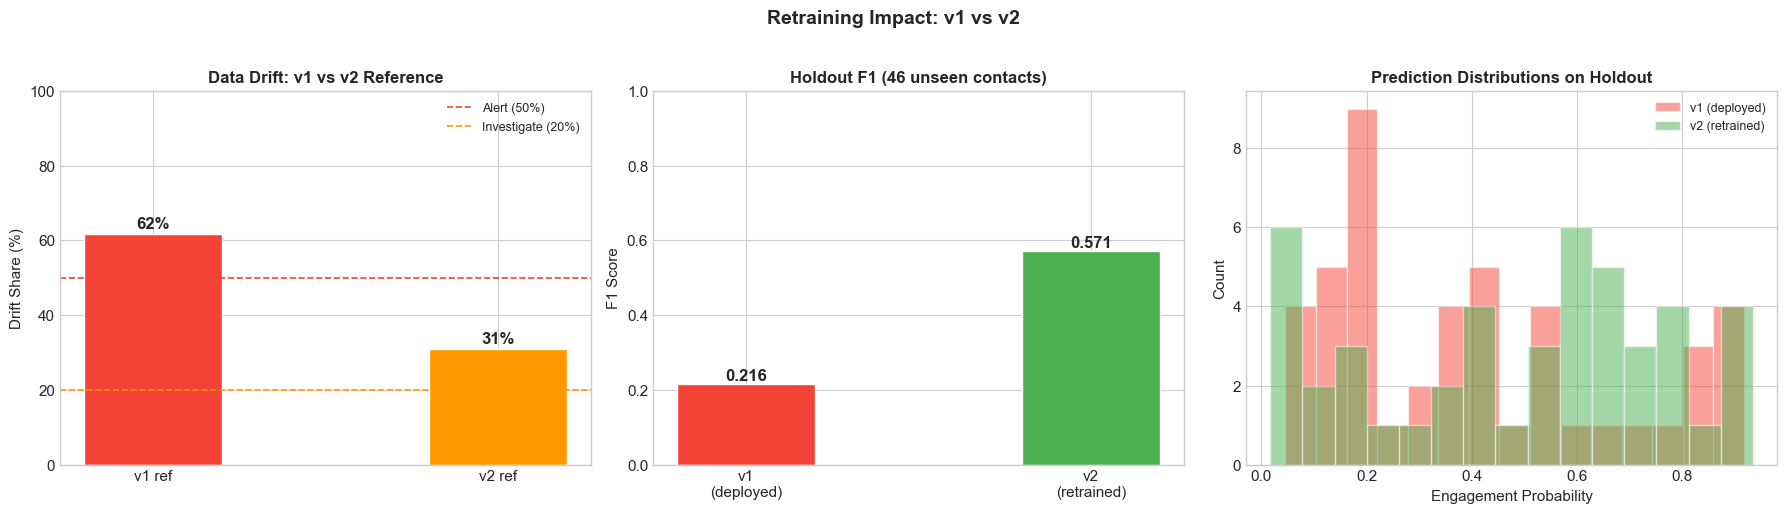


  RETRAINING IMPACT SUMMARY
  v1 on all 151 production contacts: F1 = 0.418
  Fair holdout comparison (46 contacts):
    v1 F1: 0.216 -> v2 F1: 0.571 (+0.355)
  Drift: 62% (v1 ref) -> 31% (v2 ref)


In [30]:
# ============================================================
# PART A: v1 on ALL 151 production contacts (fair — never saw this data)
# ============================================================
actuals_all = production_raw["engaged"].values

v1_all_scores = model_v1.predict_proba(production_features[feature_columns])[:, 1]
v1_all_binary = (v1_all_scores >= 0.5).astype(int)
v1_all_f1 = f1_score(actuals_all, v1_all_binary)
v1_all_prec = precision_score(actuals_all, v1_all_binary)
v1_all_rec = recall_score(actuals_all, v1_all_binary)

print("=== v1 PRODUCTION PERFORMANCE on ALL 151 contacts ===")
print(f"  F1:        {v1_all_f1:.3f}")
print(f"  Precision: {v1_all_prec:.3f}")
print(f"  Recall:    {v1_all_rec:.3f}")
print(f"  (v1 trained on original 303 contacts only — no data leakage)")

# ============================================================
# PART B: Fair v1 vs v2 comparison on HOLDOUT (~45 contacts)
# v2 trained on ~106 of the 151, holdout is unseen by both
# ============================================================

# v1 on holdout (using v1 preprocessing)
v1_ho_scores = model_v1.predict_proba(holdout_features_v1[feature_columns])[:, 1]
v1_ho_binary = (v1_ho_scores >= 0.5).astype(int)
v1_ho_f1 = f1_score(holdout_actuals, v1_ho_binary)
v1_ho_prec = precision_score(holdout_actuals, v1_ho_binary)
v1_ho_rec = recall_score(holdout_actuals, v1_ho_binary)

# v2 on holdout (using v2 preprocessing)
v2_ho_scores = model_v2.predict_proba(holdout_features_v2[v2_feature_columns])[:, 1]
v2_ho_binary = (v2_ho_scores >= 0.5).astype(int)
v2_ho_f1 = f1_score(holdout_actuals, v2_ho_binary)
v2_ho_prec = precision_score(holdout_actuals, v2_ho_binary)
v2_ho_rec = recall_score(holdout_actuals, v2_ho_binary)

print(f"\n=== FAIR v1 vs v2 COMPARISON on HOLDOUT ({len(holdout_actuals)} unseen contacts) ===\n")
print(f"  {'Metric':<12} {'v1 (deployed)':>14} {'v2 (retrained)':>14} {'delta':>10}")
print(f"  {'-'*50}")
print(f"  {'F1':<12} {v1_ho_f1:>14.3f} {v2_ho_f1:>14.3f} {v2_ho_f1 - v1_ho_f1:>+10.3f}")
print(f"  {'Precision':<12} {v1_ho_prec:>14.3f} {v2_ho_prec:>14.3f} {v2_ho_prec - v1_ho_prec:>+10.3f}")
print(f"  {'Recall':<12} {v1_ho_rec:>14.3f} {v2_ho_rec:>14.3f} {v2_ho_rec - v1_ho_rec:>+10.3f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Drift share comparison
ax = axes[0]
names_cmp = ["v1 ref", "v2 ref"]
shares_cmp = [prod_drift["drift_share"], prod_drift_v2["drift_share"]]
colors_cmp = [ALERT_COLOR if s >= 0.5 else (PROD_COLOR if s >= 0.2 else OK_COLOR) for s in shares_cmp]
bars = ax.bar(names_cmp, [s * 100 for s in shares_cmp], color=colors_cmp, edgecolor="white", width=0.4)
ax.axhline(50, color=ALERT_COLOR, linestyle="--", linewidth=1.2, label="Alert (50%)")
ax.axhline(20, color=PROD_COLOR, linestyle="--", linewidth=1.2, label="Investigate (20%)")
for bar, s in zip(bars, shares_cmp):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1.5,
            f"{s:.0%}", ha="center", fontsize=12, fontweight="bold")
ax.set_ylabel("Drift Share (%)")
ax.set_title("Data Drift: v1 vs v2 Reference", fontsize=12, fontweight="bold")
ax.set_ylim(0, 100)
ax.legend(fontsize=9)

# F1 comparison on holdout
ax = axes[1]
f1_values = [v1_ho_f1, v2_ho_f1]
f1_labels = ["v1\n(deployed)", "v2\n(retrained)"]
f1_colors = [ALERT_COLOR, OK_COLOR]
bars = ax.bar(f1_labels, f1_values, color=f1_colors, edgecolor="white", width=0.4)
for bar, val in zip(bars, f1_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
            f"{val:.3f}", ha="center", fontsize=12, fontweight="bold")
ax.set_ylabel("F1 Score")
ax.set_title(f"Holdout F1 ({len(holdout_actuals)} unseen contacts)", fontsize=12, fontweight="bold")
ax.set_ylim(0, 1.0)

# Prediction distributions on holdout
ax = axes[2]
ax.hist(v1_ho_scores, bins=15, alpha=0.5, color=ALERT_COLOR, label="v1 (deployed)", edgecolor="white")
ax.hist(v2_ho_scores, bins=15, alpha=0.5, color=OK_COLOR, label="v2 (retrained)", edgecolor="white")
ax.set_xlabel("Engagement Probability")
ax.set_ylabel("Count")
ax.set_title("Prediction Distributions on Holdout", fontsize=12, fontweight="bold")
ax.legend(fontsize=9)

fig.suptitle("Retraining Impact: v1 vs v2",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*60}")
print(f"  RETRAINING IMPACT SUMMARY")
print(f"{'='*60}")
print(f"  v1 on all 151 production contacts: F1 = {v1_all_f1:.3f}")
print(f"  Fair holdout comparison ({len(holdout_actuals)} contacts):")
print(f"    v1 F1: {v1_ho_f1:.3f} -> v2 F1: {v2_ho_f1:.3f} ({v2_ho_f1 - v1_ho_f1:+.3f})")
print(f"  Drift: {prod_drift['drift_share']:.0%} (v1 ref) -> {prod_drift_v2['drift_share']:.0%} (v2 ref)")
print(f"{'='*60}")


---

## 12. Monitoring Recommendations & Decision Framework

### Summary of Findings

| Scenario | Data Drift Share | Prediction Drift | Action |
|----------|:----------------:|:-----------------:|--------|
| No-Drift Baseline | ~2% | No | Monitor (all clear) |
| Sector Shift | High | Check results above | Investigate if new verticals are permanent |
| Seniority Shift | High | Check results above | Investigate targeting strategy change |
| Geography Shift | Moderate-High | Check results above | Assess expansion impact |
| Quality Degradation | High | Check results above | Alert -- fix data pipeline first |

### Decision Framework: When to Retrain

| Metric | Threshold | Action |
|--------|-----------|--------|
| **Drift share** < 20% | Green | Continue monitoring. Normal variation. |
| **Drift share** 20-50% | Yellow | Investigate which features drifted. If business-relevant, plan retraining. |
| **Drift share** >= 50% | Red | Alert. Consider immediate retraining or rollback. |
| **Prediction drift** p-value < 0.01 | Red | Model output distribution has shifted significantly. Evaluate real-world impact. |
| **F1 on holdout** drops > 20% from baseline (0.556) | Red | Concept drift confirmed. Retrain with new labelled data. |

### Operational Monitoring Stack

- **Streamlit Dashboard**: Real-time drift metrics and prediction distributions.
  Deployed on Hugging Face Spaces for continuous visibility.
- **Evidently Reports**: Full HTML drift reports generated via `DriftDetector.generate_report()`.
  Stored per batch for audit trail.
- **Retraining Script**: `scripts/export_model.py` re-exports the model with updated data.
  MLflow tracks experiment versions and model registry manages production deployment.

### Next Steps

1. Deploy monitoring dashboard to production
2. Establish ground truth feedback loop (record outreach outcomes)
3. Set up automated drift detection on weekly batches
4. Define SLA: drift report generated within 24h of new batch ingestion

In [31]:
# Final consolidated summary
print("=" * 80)
print("  CONSOLIDATED MONITORING & RETRAINING REPORT")
print("=" * 80)

print(f"\n  Reference data:  {reference_df.shape[0]} samples, {len(feature_columns)} features")
print(f"  Model v1:        XGBoost, {len(df_original)} rows, single split (F1={metrics_v1['f1']:.3f})")
print(f"  Model v2:        XGBoost, {len(df_merged)} rows, 5-fold CV (F1={metrics_v2['f1']:.3f}+/-{std_v2['f1']:.3f})")
print(f"  Drift detector:  Evidently AI (KS test numeric, chi-squared categorical)")
print()

print("  --- SYNTHETIC SCENARIOS (v1 model) ---")
for name in all_scenario_names:
    dr = drift_results[name]
    pr = prediction_results[name]
    if dr["drift_share"] >= 0.5 or pr["drift_detected"]:
        level = "RED"
    elif dr["drift_share"] >= 0.2:
        level = "YELLOW"
    else:
        level = "GREEN"
    print(f"    {name:<25} [{level:<6}] drift={dr['drift_share']:.1%}, pred_drift={pr['drift_detected']}")

print(f"\n  --- REAL PRODUCTION DATA ---")
print(f"    All labelled (151):    drift={prod_drift['drift_share']:.1%} (v1 ref)")
print(f"    Unlabelled (277):      drift={unlabelled_drift['drift_share']:.1%}, no ground truth")

print(f"\n  --- v1 PRODUCTION PERFORMANCE (all 151 contacts) ---")
print(f"    F1={v1_all_f1:.3f}, Precision={v1_all_prec:.3f}, Recall={v1_all_rec:.3f}")

print(f"\n  --- FAIR HOLDOUT v1 vs v2 ({len(holdout_actuals)} unseen contacts) ---")
print(f"    v1 F1: {v1_ho_f1:.3f} -> v2 F1: {v2_ho_f1:.3f} ({v2_ho_f1 - v1_ho_f1:+.3f})")

print(f"\n  --- DRIFT REDUCTION ---")
print(f"    {prod_drift['drift_share']:.0%} (v1 ref) -> {prod_drift_v2['drift_share']:.0%} (v2 ref)")

print(f"\n{'='*80}")
print(f"  End of drift monitoring & retraining analysis.")
print(f"{'='*80}")


  CONSOLIDATED MONITORING & RETRAINING REPORT

  Reference data:  100 samples, 47 features
  Model v1:        XGBoost, 303 rows, single split (F1=0.375)
  Model v2:        XGBoost, 408 rows, 5-fold CV (F1=0.530+/-0.043)
  Drift detector:  Evidently AI (KS test numeric, chi-squared categorical)

  --- SYNTHETIC SCENARIOS (v1 model) ---
    No Drift (Baseline)       [GREEN ] drift=2.1%, pred_drift=False
    Sector Shift              [RED   ] drift=76.6%, pred_drift=True
    Seniority Shift           [RED   ] drift=78.7%, pred_drift=True
    Geography Shift           [RED   ] drift=70.2%, pred_drift=True
    Quality Degradation       [RED   ] drift=68.1%, pred_drift=True

  --- REAL PRODUCTION DATA ---
    All labelled (151):    drift=61.7% (v1 ref)
    Unlabelled (277):      drift=76.6%, no ground truth

  --- v1 PRODUCTION PERFORMANCE (all 151 contacts) ---
    F1=0.418, Precision=0.452, Recall=0.389

  --- FAIR HOLDOUT v1 vs v2 (46 unseen contacts) ---
    v1 F1: 0.216 -> v2 F1: 0.571 